# REFMAP laboratory listening test 1 analysis: Sound quality analysis

## Setup

In [1]:
# -*- coding: utf-8 -*-
import sys
import os
# Build a path from the notebook's parent directory to the python modules
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

# import statements
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from cycler import cycler

In [2]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 

# set numpy seed
np.random.seed(808)


Set the saveplots toggle to True if plot saving is desired:

In [3]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots '03 Experiment\Experiment 1\Analysis\Plots'")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass


Set the savedata toggle to True if data saving is desired:

In [4]:
savedata = True

if saveplots:
    # select data output save path
    outDataPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save data '03 Experiment\Experiment 1\Analysis\Python'")


## Import data and organise

In [18]:
# import test data
fileExts = "*.csv"

# Part A
dataByStimAFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdataA_ByStim.csv in: '03 Experiment\Experiment 1\Analysis\PostProcess'"))[0]
dataByStimTestA = pd.read_csv(dataByStimAFilePath, index_col=0)

dataByStimANoticeFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataANoticeFilt_ByStim.csv",
                                                             caption=r"Open refmap_listest1_testdataANoticeFilt_ByStim.csv in: '03 Experiment\Experiment 1\Analysis\PostProcess'"))[0]
dataByStimTestANotice = pd.read_csv(dataByStimANoticeFilePath, index_col=0)


# Part B
dataByStimBFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataB_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdataB_ByStim.csv in: '03 Experiment\Experiment 1\Analysis\PostProcess'"))[0]
dataByStimTestB = pd.read_csv(dataByStimBFilePath, index_col=0)

# Parts A and B

dataByStimFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdata_ByStim.csv",
                                                      caption=r"Open refmap_listest1_testdata_ByStim.csv in: '03 Experiment\Experiment 1\Analysis\PostProcess'"))[0]
dataByStimTest = pd.read_csv(dataByStimFilePath, index_col=0)


# Auxiliary data

auxDataByStimFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_auxdata.csv",
                                                         caption=r"Open refmap_listest1_auxdata.csv in: '03 Experiment\Experiment 1\Analysis\PostProcess'"))[0]
auxData =  pd.read_csv(auxDataByStimFilePath, index_col=0)
auxData.drop(index='G57_background', inplace=True)

## Data manipulation

In [20]:

# calculate alternative indices

dataByStimTestANotice['Detect0p5IntMaxLRLog'] = dataByStimTestANotice['Detect0p5dBIntMaxLR']/10
dataByStimTestANotice['Detect0p5MaxMaxLRLog'] = dataByStimTestANotice['Detect0p5dBMaxMaxLR']/10
dataByStimTestANotice['Detect0p1IntMaxLRLog'] = dataByStimTestANotice['Detect0p1dBIntMaxLR']/10
dataByStimTestANotice['Detect0p1MaxMaxLRLog'] = dataByStimTestANotice['Detect0p1dBMaxMaxLR']/10


dataByStimTest['Detect0p5IntMaxLRLog'] = dataByStimTest['Detect0p5dBIntMaxLR']/10
dataByStimTest['Detect0p5MaxMaxLRLog'] = dataByStimTest['Detect0p5dBMaxMaxLR']/10
dataByStimTest['Detect0p1IntMaxLRLog'] = dataByStimTest['Detect0p1dBIntMaxLR']/10
dataByStimTest['Detect0p1MaxMaxLRLog'] = dataByStimTest['Detect0p1dBMaxMaxLR']/10

In [35]:
# categorise columns

for dataset in [dataByStimTestA, dataByStimTestANotice, dataByStimTest]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Overflight", "Landing", "Takeoff"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "M300", "T150"], ordered=True)

for dataset in [dataByStimTestB]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Overflight"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "T150"], ordered=True)

for dataset in [auxData]:
    # ensure 'UASLAeq' field is parsed as categorical with correct order
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'].astype(int).astype(str), ["42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["Overflight", "Landing", "Takeoff"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["H520", "M300", "T150"], ordered=True)


DON'T RUN THE NEXT BLOCK UNLESS NEEDING TIME-DEPENDENT DATA - EXCESSIVE LOADING TIME

In [ ]:
## !!!ONLY RUN IF NEEDED - TIME-INTENSIVE LOADING BLOCK!!!

# import SQM time-dependent data
fileExts = "*.xlsx"
filelist = list(QFileDialog.getOpenFileNames(filter=fileExts,
                                             caption=r"Select SQM analysis files in: \03 Experiment\Experiment 1\Analysis\ArtemiS\Output_new"))[0]
filelist.sort()
filenames = [filepath.split('/')[-1] for filepath in filelist]
A1_SQM = pd.read_excel(io=filelist[0], sheet_name=None)
A2_SQM = pd.read_excel(io=filelist[1], sheet_name=None)
H520_F_1_SQM = pd.read_excel(io=filelist[2], sheet_name=None)
H520_L_1_SQM = pd.read_excel(io=filelist[3], sheet_name=None)
H520_T_1_SQM = pd.read_excel(io=filelist[4], sheet_name=None)
M300_F_1_SQM = pd.read_excel(io=filelist[5], sheet_name=None)
M300_L_1_SQM = pd.read_excel(io=filelist[6], sheet_name=None)
M300_T_1_SQM = pd.read_excel(io=filelist[7], sheet_name=None)
T150_F_1_SQM = pd.read_excel(io=filelist[8], sheet_name=None)
T150_L_1_SQM = pd.read_excel(io=filelist[9], sheet_name=None)
T150_T_1_SQM = pd.read_excel(io=filelist[10], sheet_name=None)

## Functions

### Traditional rounding (for display)

In [ ]:
def roundTrad(val, digits=3):
   return round(val+10**(-len(str(val))-1), digits)

In [10]:
def displayRndVal(val, digits=3):

    crit = 1/10**digits

    if val < crit:
        valString = "<" + str(crit)
    else:
        valRnd = roundTrad(val, digits)
        dec = int(str(valRnd).split('.')[-1])
        valString = str(valRnd)
        nzeros = digits - len(str(dec))
        if nzeros > 0:
            valString = valString + nzeros*"0"

    return(valString)

## Stimuli sound quality analysis

### Time-aggregated

#### Spider plot function

Below is a function that generates a radar (spider) plot with varying axis scalings.

In [11]:
def spider(df, *, id_column, title=None, max_values=None, padding=1.25, axsize=12,
           labelsize=12, legsize=12, palette=None,
           savefigpath=False, savefigfmt='svg'):
    categories = df._get_numeric_data().columns.tolist()
    data = df[categories].to_dict(orient='list')
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding*max(value) for key, value in data.items()}
    else:
        keys = [key for key in data.keys()]
        values =  [max_value for max_value in max_values]
        max_values = dict(map(lambda i, j: (i, j), keys, values))
    
    normalized_data = {key: np.array(value) / max_values[key] for key, value in data.items()}
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist() + [0.0]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    if palette is None:
        pass
    else:
        try:
            ax.set_prop_cycle(cycler(color=palette))
        except TypeError:
            raise TypeError

    for ii, model_name in enumerate(ids):
        values = [normalized_data[key][ii] for key in data.keys()]
        actual_values = [data[key][ii] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        line, = ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.1)

        for ii, (_x, _y, t) in enumerate(zip(angles, values, actual_values)):
            t = f'{t:.3f}' if isinstance(t, float) else str(t)
            ax.text(_x, _y, t, size=labelsize, color=line.get_color())
            
    ax.fill(angles, np.ones(num_vars + 1), alpha=0.01)
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks, fontsize=axsize)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=legsize)
    if title is not None: plt.suptitle(title)
    if savefigpath != False:
        try:
            if type(savefigfmt) is list:
                for ii, fmt in enumerate(savefigfmt):
                    if type(savefigpath) is list:
                        plt.savefig(savefigpath[ii], format=savefigfmt[ii])
                    else:
                        plt.savefig(savefigpath, format=savefigfmt[ii])
            else:
                plt.savefig(savefigpath, format=savefigfmt)
        except ValueError:
            raise ValueError
    plt.show()

In [49]:
# prepare subdata frame 
df_SQM = auxData.loc[(auxData['UASLAeq'] == '60') &
                     (auxData['SessionPart'] == 'A'), ['UASType', 'UASOperation',
                              'LoudECMAPowAvgBin', 'SharpAurISO305ExBin',
                              'TonalSHMInt05ExMaxLR', 'FluctECMA10ExBin',
                              'RoughFZ05ExMaxLR', 'ImpulsLoudWZAvgMaxLR']]

max_values = np.round(np.max(df_SQM.iloc[:, 2:], axis=0)*1.1, 3)


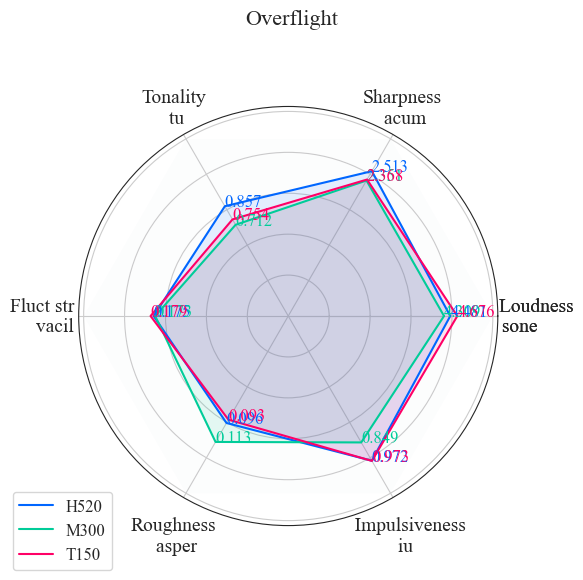

In [50]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = [os.path.join(outFigPath, "svg", "UASSQMOverflight.svg"),
                   os.path.join(outFigPath, "pdf", "UASSQMOverflight.pdf")]
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Overflight',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath,
    savefigfmt=['svg', 'pdf'])


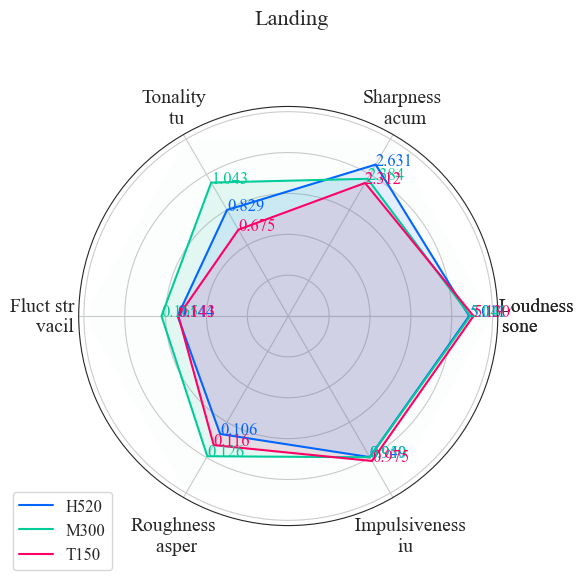

In [51]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = [os.path.join(outFigPath, "svg", "UASSQMLanding.svg"),
                   os.path.join(outFigPath, "pdf", "UASSQMLanding.pdf")]
                   
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Landing',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath,
    savefigfmt=['svg', 'pdf'])


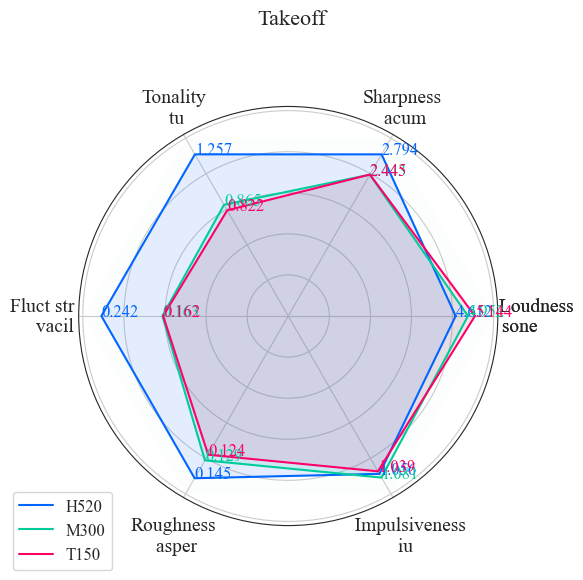

In [52]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = [os.path.join(outFigPath, "svg", "UASSQMTakeoff.svg"),
                   os.path.join(outFigPath, "pdf", "UASSQMTakeoff.pdf")]
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Takeoff',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath,
    savefigfmt=['svg', 'pdf'])

### Time-aggregated (repeat)

Radar analysis repeated with tonal loudness instead of (integrated) tonality

In [53]:
# prepare subdata frame 
df_SQM = auxData.loc[(auxData['UASLAeq'] == '60') &
                     (auxData['SessionPart'] == 'A'), ['UASType', 'UASOperation',
                              'LoudECMAPowAvgBin', 'SharpAurISO305ExBin',
                              'TonLdECMAPowAvgBin', 'FluctECMA10ExBin',
                              'RoughFZ05ExMaxLR', 'ImpulsLoudWZAvgMaxLR']]

max_values = np.round(np.max(df_SQM.iloc[:, 2:], axis=0)*1.1, 3)


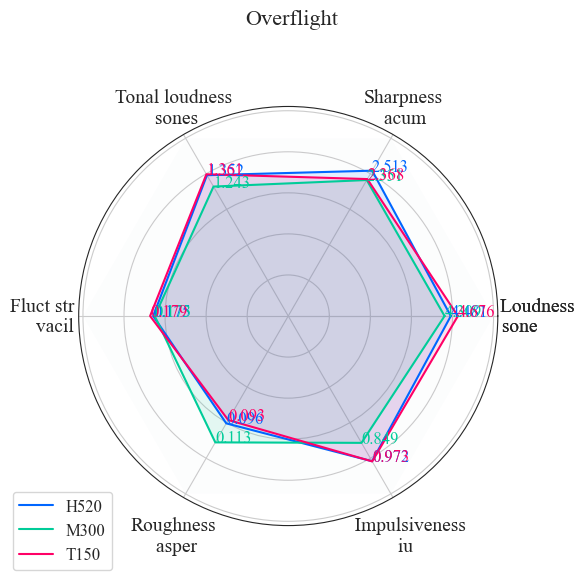

In [54]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[3]].values, 3),
        'Tonal loudness\n sones\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Overflight'), df_SQM.columns[7]].values, 3)
    })


if saveplots:
    savefigpath = [os.path.join(outFigPath, "svg", "UASSQMOverflightTLd.svg"),
                   os.path.join(outFigPath, "pdf", "UASSQMOverflightTLd.pdf")]
else:
    savefigpath = False
    
spider(
    data,
    id_column='UASType',
    title='Overflight',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath,
    savefigfmt=['svg', 'pdf'])


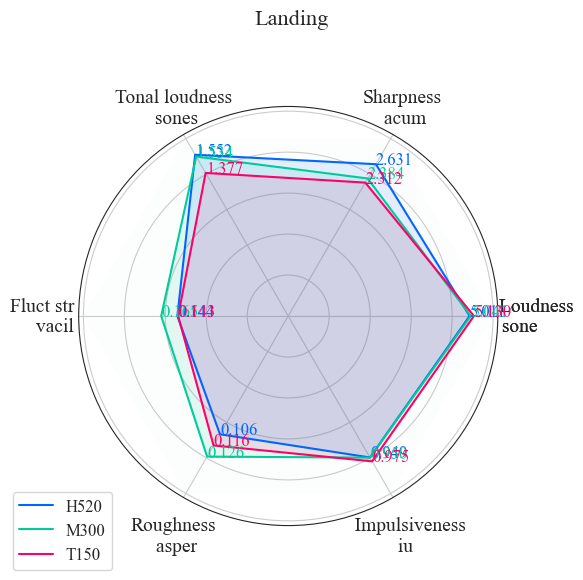

In [55]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[3]].values, 3),
        'Tonal loudness\n sones\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = [os.path.join(outFigPath, "svg", "UASSQMLandingTLd.svg"),
                   os.path.join(outFigPath, "pdf", "UASSQMLandingTLd.pdf")]
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Landing',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath,
    savefigfmt=['svg', 'pdf'])

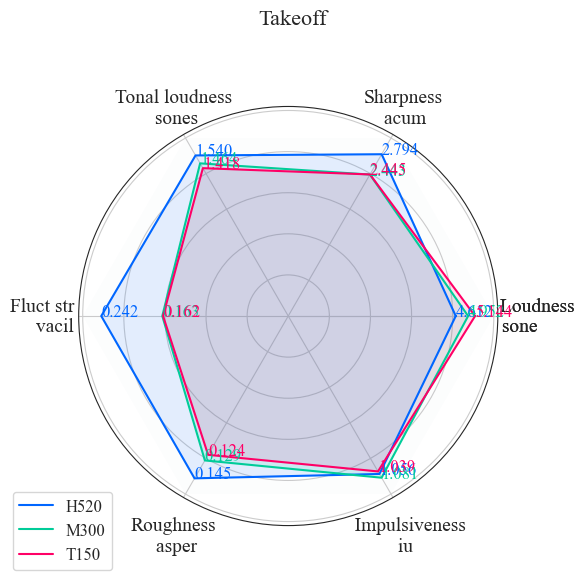

In [56]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[3]].values, 3),
        'Tonal loudness\n sones\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = [os.path.join(outFigPath, "svg", "UASSQMTakeoffTLd.svg"),
                   os.path.join(outFigPath, "pdf", "UASSQMTakeoffTLd.pdf")]
else:
    savefigpath = False

spider(data,
       id_column='UASType',
       title='Takeoff',
       max_values=max_values,
       padding=1.15,
       axsize=14,
       palette=mycolours,
       savefigpath=savefigpath,
       savefigfmt=['svg', 'pdf'])

## Loudness/level comparison

In [11]:
def lowess_with_confidence_bounds(
    data, x, y, xvals=None, n_boot=1000, conf_interval=0.95, lowess_kw={}):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """

    x = data[x]
    y = data[y]

    if xvals is None:
        xvals = x.sort_values().values
    
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=xvals, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((n_boot, len(xvals)))
    for i in range(n_boot):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x.values[sample]
        sampled_y = y.values[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=xvals, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(n_boot * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


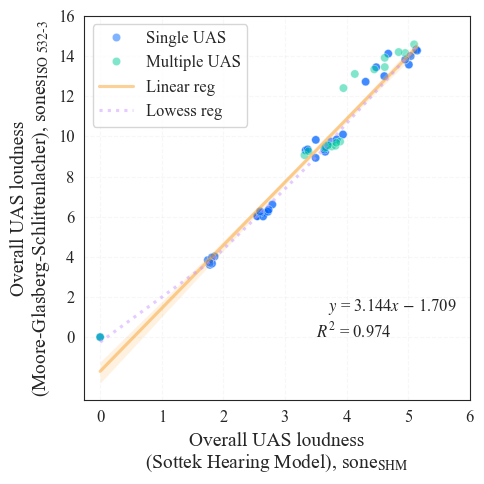

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLoudECMAPowAvgBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudECMAPowAvgBin', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudECMAPowAvgBin', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudECMAPowAvgBin', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel="Overall UAS loudness" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       ylabel="Overall UAS loudness" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sones$_\text{ISO 532-3}$",
       xticks=range(0, 7), yticks=range(0, 18, 2))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=3.5, y=0, s=r"$R^2$ = " + str(round(res.rsquared, 3)))
ax.text(x=3.5, y=1.3,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" +" " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO3vNSHM"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

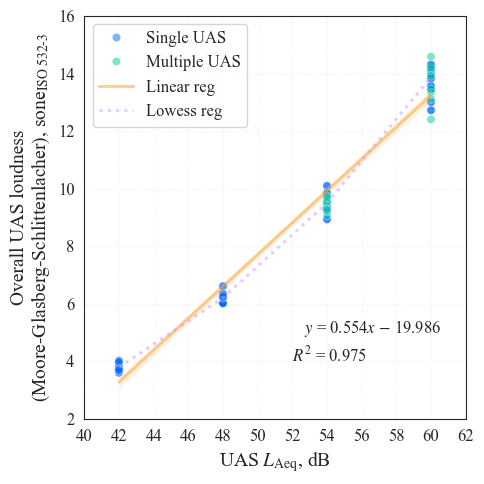

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])  # this is a fast way to strip the categories from the data frames when omitting the No UAS data for dB metrics
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLAeq']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAeq', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel=r"UAS $L_\text{Aeq}$, dB",
       ylabel="Overall UAS loudness" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sone$_\text{ISO 532-3}$",
       xticks=range(40, 64, 2), yticks=range(2, 18, 2))
ax.text(x=52, y=4, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=52, y=5,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO3vLAeq"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

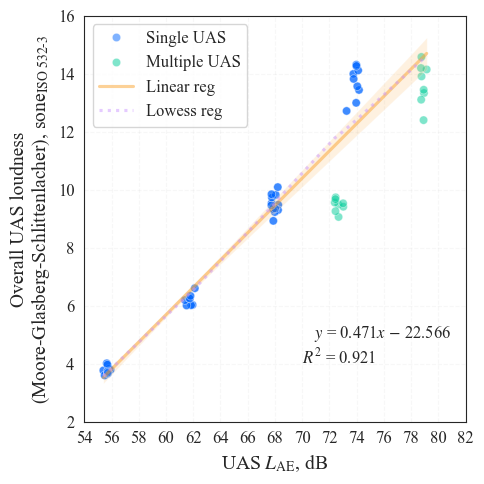

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])  # this is a fast way to strip the categories from the data frames
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLAEMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAEMaxLR', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAEMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLAEMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel=r"UAS $L_\text{AE}$, dB",
       ylabel="Overall UAS loudness" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sone$_\text{ISO 532-3}$",
       xticks=range(54, 84, 2), yticks=range(2, 18, 2))
ax.text(x=70, y=4, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=70, y=4.9,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO3vLAE"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

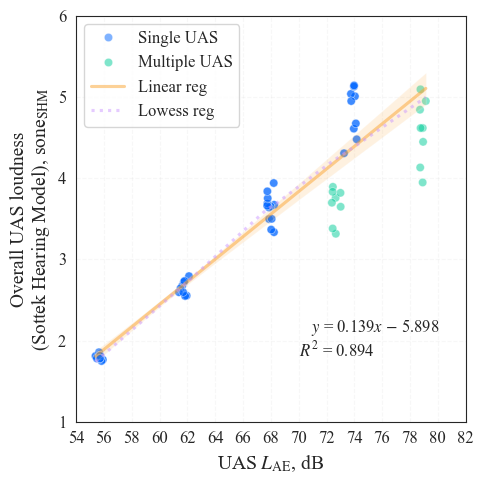

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])  # this is a fast way to strip the categories from the data frames when omitting the No UAS data for dB metrics
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAPowAvgBin'], sm.add_constant(data['UASLAEMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAEMaxLR', y='UASLoudECMAPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAEMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLAEMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')

ax.set(xlabel=r"UAS $L_\text{AE}$, dB",
       ylabel="Overall UAS loudness" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xticks=range(54, 84, 2), yticks=range(1, 7))
ax.text(x=70, y=1.8, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=70, y=2.1,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNSHMvLAE"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

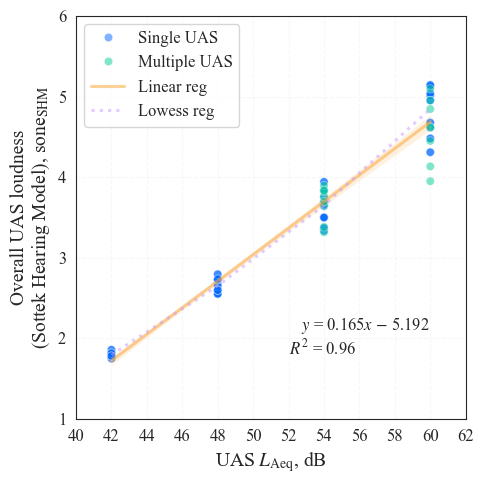

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])  # this is a fast way to strip the categories from the data frames when omitting the No UAS data for dB metrics
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAPowAvgBin'], sm.add_constant(data['UASLAeq']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAeq', y='UASLoudECMAPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAeq', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLAeq', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')

ax.set(xlabel=r"UAS $L_\text{Aeq}$, dB",
       ylabel="Overall UAS loudness"+ "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xticks=range(40, 64, 2), yticks=range(1, 7))
ax.text(x=52, y=1.8, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=52, y=2.1,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNSHMvLAeq"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

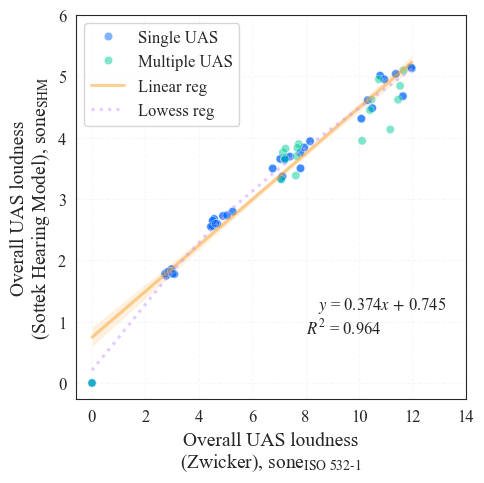

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAPowAvgBin'], sm.add_constant(data['UASLoudISO1PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudECMAPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall UAS loudness" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xlabel="Overall UAS loudness" + "\n" + "(Zwicker), " + r"sone$_{\text{ISO 532-1}}$",
       yticks=range(0, 7), xticks=range(0, 16, 2))
ax.text(x=8, y=0.8, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=8, y=1.2,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNSHMvNISO1"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

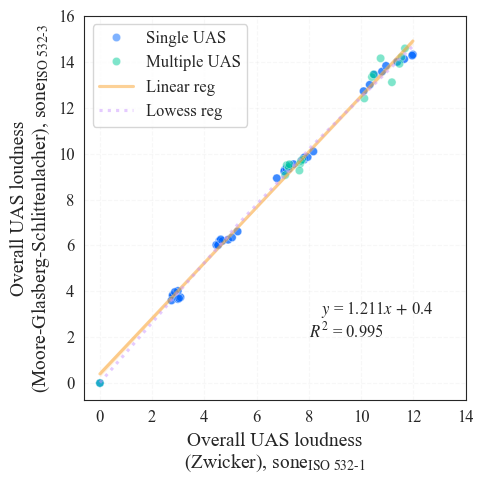

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLoudISO1PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel="Overall UAS loudness" + "\n" + "(Zwicker), " + r"sone$_\text{ISO 532-1}$",
       ylabel="Overall UAS loudness" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sone$_\text{ISO 532-3}$",
       xticks=range(0, 16, 2), yticks=range(0, 18, 2))
ax.text(x=8, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=8, y=3,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO3vNISO1"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

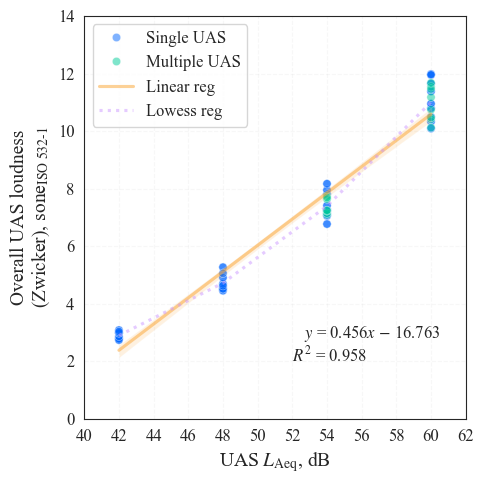

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])  # this is a fast way to strip the categories from the data frames when omitting the No UAS data for dB metrics
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO1PowAvgMaxLR'], sm.add_constant(data['UASLAeq']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAeq', y='UASLoudISO1PowAvgMaxLR', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel=r"UAS $L_\text{Aeq}$, dB",
       ylabel="Overall UAS loudness" + "\n" + "(Zwicker), " + r"sone$_\text{ISO 532-1}$",
       xticks=range(40, 64, 2), yticks=range(0, 16, 2))
ax.text(x=52, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=52, y=2.8,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO1vLAeq"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

### Proxy metrics for sound quality

#### Loudness

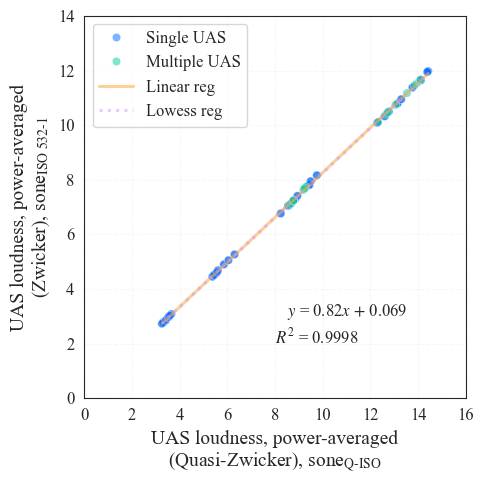

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO1PowAvgMaxLR'], sm.add_constant(data['UASLoudQZ5321PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudISO1PowAvgMaxLR', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS loudness, power-averaged" + "\n" + "(Zwicker), " + r"sone$_\text{ISO 532-1}$",
       xlabel="UAS loudness, power-averaged" + "\n" + "(Quasi-Zwicker), " + r"sone$_\text{Q-ISO}$",
       yticks=range(0, 16, 2), xticks=range(0, 18, 2))
ax.text(x=8, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=8, y=3,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO1vNQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

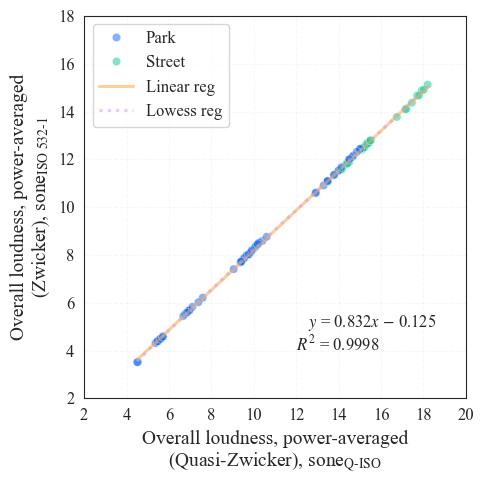

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['LoudISO1PowAvgMaxLR'], sm.add_constant(data['LoudQZ5321PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudISO1PowAvgMaxLR', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall loudness, power-averaged" + "\n" + "(Zwicker), " + r"sone$_\text{ISO 532-1}$",
       xlabel="Overall loudness, power-averaged" + "\n" + "(Quasi-Zwicker), " + r"sone$_\text{Q-ISO}$",
       yticks=range(2, 20, 2), xticks=range(2, 22, 2))
ax.text(x=12, y=4, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=12, y=5,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallNISO1vNQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

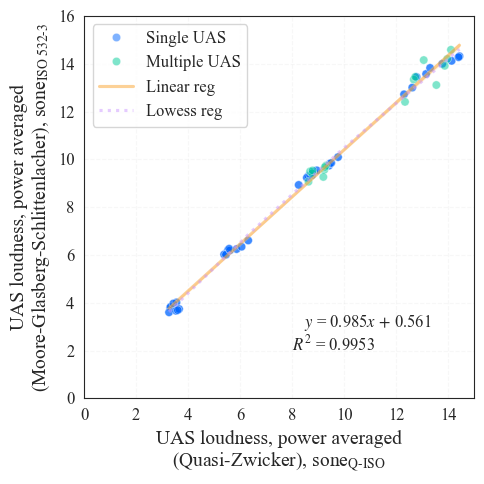

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLoudQZ5321PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS loudness, power averaged" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sone$_\text{ISO 532-3}$",
       xlabel="UAS loudness, power averaged" + "\n" + "(Quasi-Zwicker), " + r"sone$_\text{Q-ISO}$",
       yticks=range(0, 18, 2), xticks=range(0, 16, 2))
ax.text(x=8, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=8, y=3,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO3vNQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

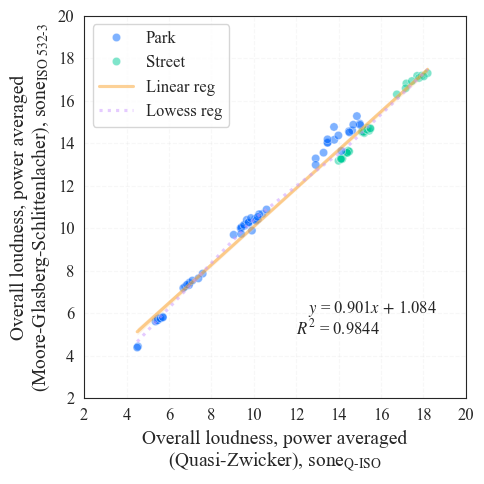

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['LoudISO3PowAvgBin'], sm.add_constant(data['LoudQZ5321PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudISO3PowAvgBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall loudness, power averaged" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sone$_\text{ISO 532-3}$",
       xlabel="Overall loudness, power averaged" + "\n" + "(Quasi-Zwicker), " + r"sone$_\text{Q-ISO}$",
       yticks=range(2, 22, 2), xticks=range(2, 22, 2))
ax.text(x=12, y=5, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=12, y=6,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallNISO3vNQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

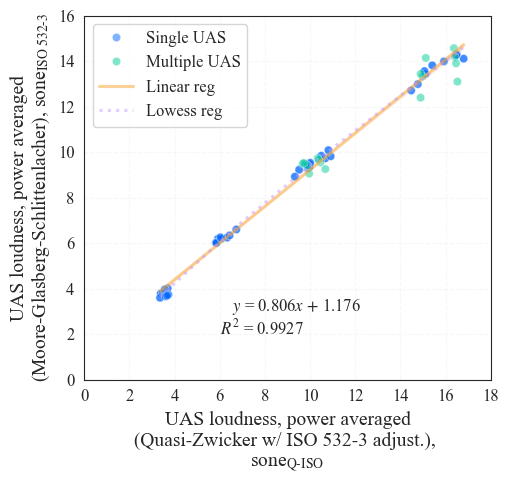

In [39]:
fig, ax = plt.subplots(figsize=(5.25, 5))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLoudQZ5323PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudQZ5323PowAvgMaxLR', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudQZ5323PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudQZ5323PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS loudness, power averaged" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sone$_\text{ISO 532-3}$",
       xlabel="UAS loudness, power averaged" + "\n" + "(Quasi-Zwicker w/ ISO 532-3 adjust.), " + "\n" + r"sone$_\text{Q-ISO}$",
       yticks=range(0, 18, 2), xticks=range(0, 20, 2))
ax.text(x=6, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=6, y=3,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNISO3vNQZ5323"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

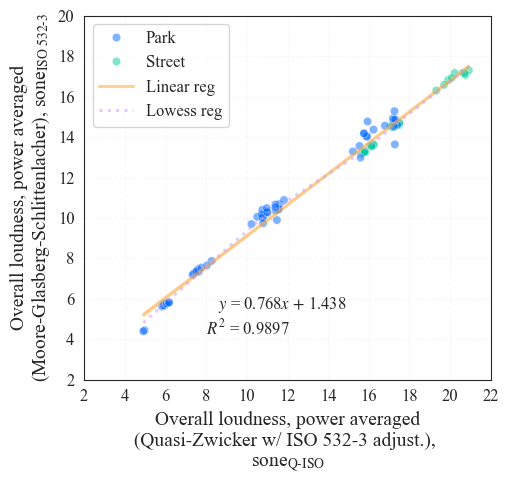

In [40]:
fig, ax = plt.subplots(figsize=(5.25, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['LoudISO3PowAvgBin'], sm.add_constant(data['LoudQZ5323PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='LoudQZ5323PowAvgMaxLR', y='LoudISO3PowAvgBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='LoudQZ5323PowAvgMaxLR', y='LoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='LoudQZ5323PowAvgMaxLR', y='LoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall loudness, power averaged" + "\n" + "(Moore-Glasberg-Schlittenlacher), " + r"sone$_\text{ISO 532-3}$",
       xlabel="Overall loudness, power averaged" + "\n" + "(Quasi-Zwicker w/ ISO 532-3 adjust.), " + "\n" + r"sone$_\text{Q-ISO}$",
       yticks=range(2, 22, 2), xticks=range(2, 24, 2))
ax.text(x=8, y=4.25, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=8, y=5.5,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallNISO3vNQZ5323"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

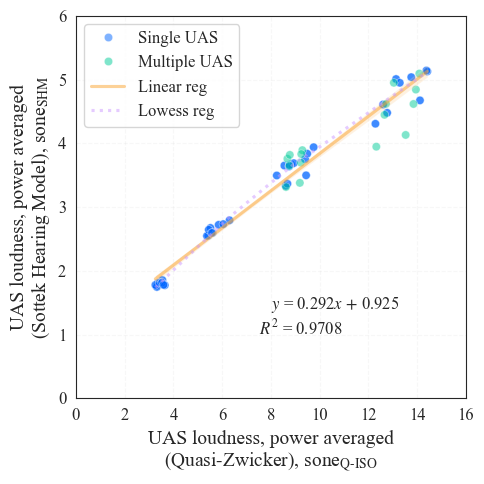

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAPowAvgBin'], sm.add_constant(data['UASLoudQZ5321PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudECMAPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudQZ5321PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS loudness, power averaged" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xlabel="UAS loudness, power averaged" + "\n" + "(Quasi-Zwicker), " + r"sone$_\text{Q-ISO}$",
       yticks=range(0, 7, 1), xticks=range(0, 18, 2))
ax.text(x=7.5, y=1, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=7.5, y=1.4,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNSHMvNQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

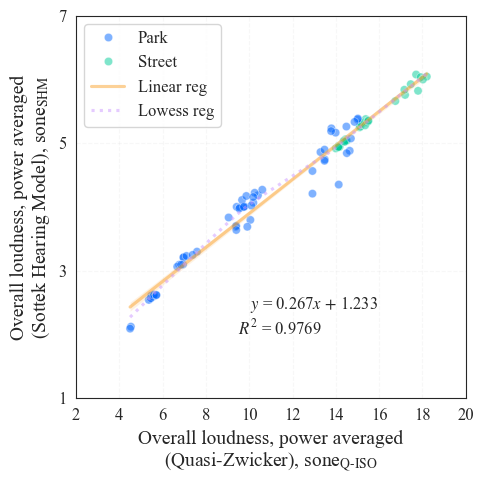

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['LoudECMAPowAvgBin'], sm.add_constant(data['LoudQZ5321PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudECMAPowAvgBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='LoudQZ5321PowAvgMaxLR', y='LoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall loudness, power averaged" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xlabel="Overall loudness, power averaged" + "\n" + "(Quasi-Zwicker), " + r"sone$_\text{Q-ISO}$",
       yticks=range(1, 8, 2), xticks=range(2, 22, 2))
ax.text(x=9.5, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=9.5, y=2.4,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallNSHMvNQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

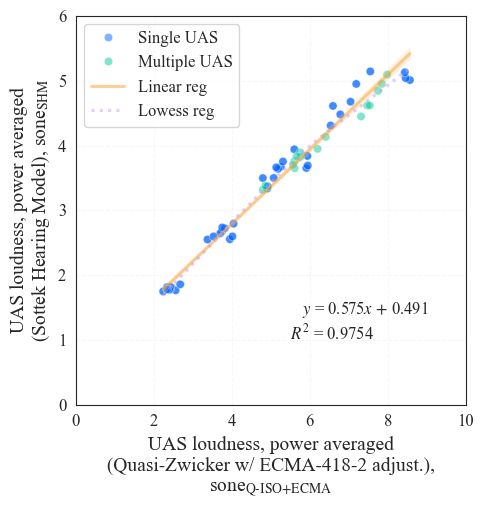

In [50]:
fig, ax = plt.subplots(figsize=(5, 5.25))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAPowAvgBin'], sm.add_constant(data['UASLoudQZ4182PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudQZ4182PowAvgMaxLR', y='UASLoudECMAPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudQZ4182PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudQZ4182PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS loudness, power averaged" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xlabel="UAS loudness, power averaged" + "\n" + "(Quasi-Zwicker w/ ECMA-418-2 adjust.)," + "\n" + r"sone$_\text{Q-ISO+ECMA}$",
       yticks=range(0, 7, 1), xticks=range(0, 12, 2))
ax.text(x=5.5, y=1, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=5.5, y=1.4,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatNSHMvNQZ4182"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

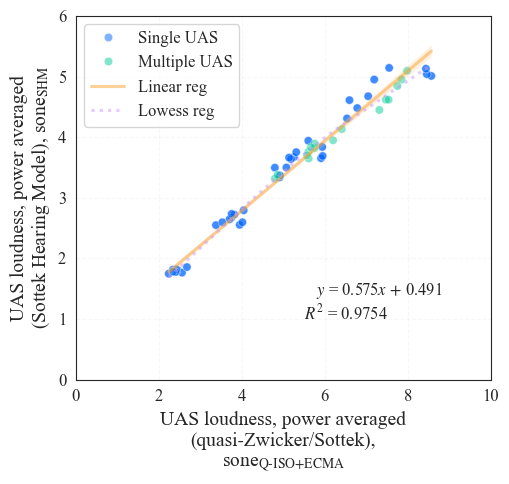

In [51]:
fig, ax = plt.subplots(figsize=(5.25, 5))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAPowAvgBin'], sm.add_constant(data['UASLoudQZ4182PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudQZ4182PowAvgMaxLR', y='UASLoudECMAPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudQZ4182PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASLoudQZ4182PowAvgMaxLR', y='UASLoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS loudness, power averaged" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xlabel="UAS loudness, power averaged" + "\n" + "(quasi-Zwicker/Sottek)," + "\n" + r"sone$_\text{Q-ISO+ECMA}$",
       yticks=range(0, 7, 1), xticks=range(0, 12, 2))
ax.text(x=5.5, y=1, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=5.5, y=1.4,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "FigSQscatNSHMvNQZ4182"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

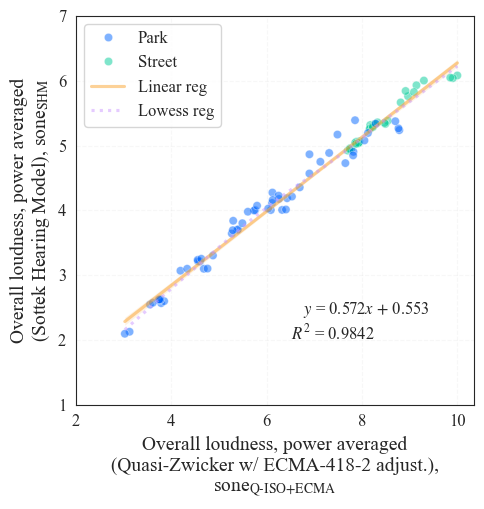

In [41]:
fig, ax = plt.subplots(figsize=(5, 5.25))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['LoudECMAPowAvgBin'], sm.add_constant(data['LoudQZ4182PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='LoudQZ4182PowAvgMaxLR', y='LoudECMAPowAvgBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='LoudQZ4182PowAvgMaxLR', y='LoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='LoudQZ4182PowAvgMaxLR', y='LoudECMAPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall loudness, power averaged" + "\n" + "(Sottek Hearing Model), " + r"sone$_\text{SHM}$",
       xlabel="Overall loudness, power averaged" + "\n" + "(Quasi-Zwicker w/ ECMA-418-2 adjust.)," + "\n" + r"sone$_\text{Q-ISO+ECMA}$",
       yticks=range(1, 8, 1), xticks=range(2, 12, 2))
ax.text(x=6.5, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=6.5, y=2.4,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallNSHMvNQZ4182"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

#### Sharpness

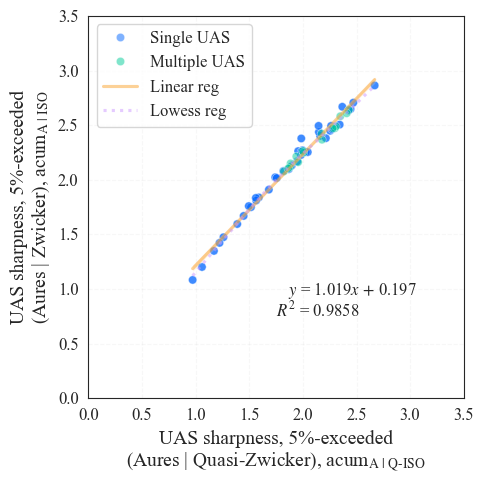

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

# filter out 'No UAS' sounds
data = data.loc[data['UASLAeq'] != 'No UAS', :]

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASSharpAurISO105ExBin'], sm.add_constant(data['UASSharpAurQZ532105ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurISO105ExBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurISO105ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurISO105ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Zwicker), " + r"acum$_\text{A | ISO}$",
       xlabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker), " + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(0, 4, 0.5), xticks=np.arange(0, 4, 0.5))
ax.text(x=1.75, y=0.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=1.75, y=0.95,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatSAISO1vSAQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

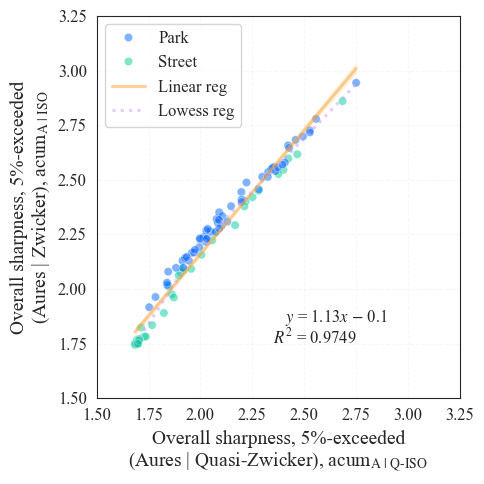

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['SharpAurISO105ExBin'], sm.add_constant(data['SharpAurQZ532105ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurISO105ExBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurISO105ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurISO105ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Zwicker), " + r"acum$_\text{A | ISO}$",
       xlabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker), " + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(1.5, 3.5, 0.25), xticks=np.arange(1.5, 3.5, 0.25))
ax.text(x=2.35, y=1.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=2.35, y=1.85,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallSAISO1vSAQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

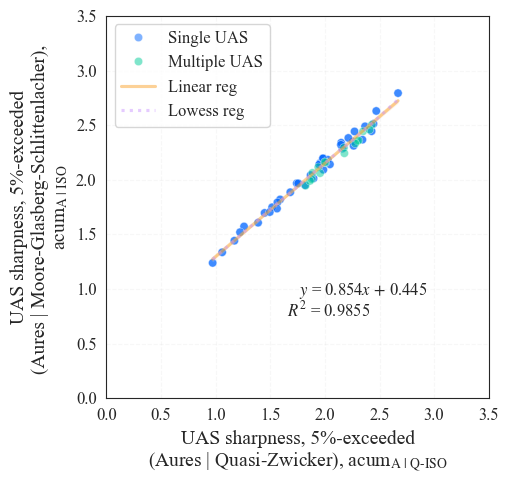

In [34]:
fig, ax = plt.subplots(figsize=(5.25, 5))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASSharpAurISO305ExBin'], sm.add_constant(data['UASSharpAurQZ532105ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurISO305ExBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Moore-Glasberg-Schlittenlacher), " + "\n" + r"acum$_\text{A | ISO}$",
       xlabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker), " + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(0, 4, 0.5), xticks=np.arange(0, 4, 0.5))
ax.text(x=1.65, y=0.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=1.65, y=0.95,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatSAISO3vSAQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

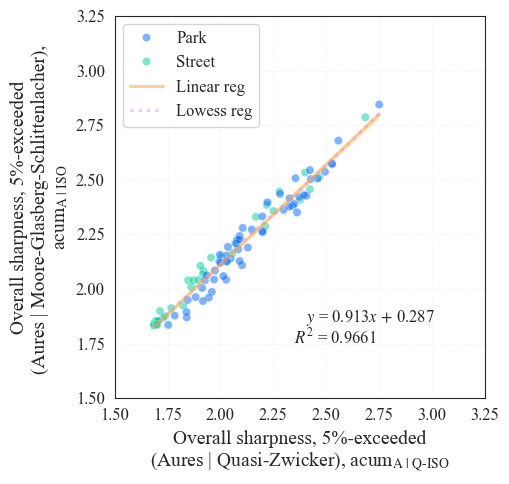

In [35]:
fig, ax = plt.subplots(figsize=(5.25, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['SharpAurISO305ExBin'], sm.add_constant(data['SharpAurQZ532105ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurISO305ExBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Moore-Glasberg-Schlittenlacher), " + "\n" + r"acum$_\text{A | ISO}$",
       xlabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker), " + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(1.5, 3.5, 0.25), xticks=np.arange(1.5, 3.5, 0.25))
ax.text(x=2.35, y=1.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=2.35, y=1.85,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallSAISO3vSAQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

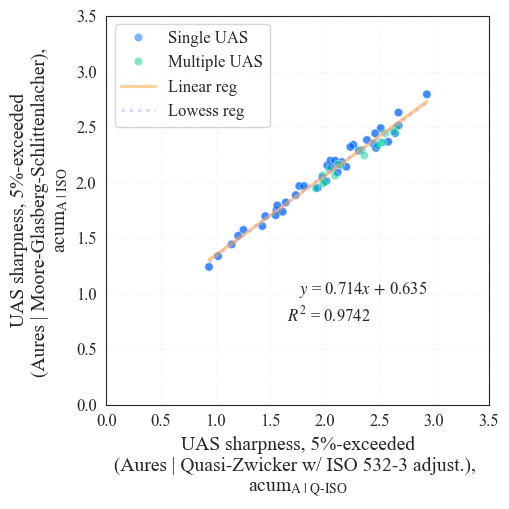

In [52]:
fig, ax = plt.subplots(figsize=(5.25, 5.25))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASSharpAurISO305ExBin'], sm.add_constant(data['UASSharpAurQZ532305ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASSharpAurQZ532305ExBin', y='UASSharpAurISO305ExBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASSharpAurQZ532305ExBin', y='UASSharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASSharpAurQZ532305ExBin', y='UASSharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Moore-Glasberg-Schlittenlacher), " + "\n" + r"acum$_\text{A | ISO}$",
       xlabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker w/ ISO 532-3 adjust.), " + "\n" + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(0, 4, 0.5), xticks=np.arange(0, 4, 0.5))
ax.text(x=1.65, y=0.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=1.65, y=1.0,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatSAISO3vSAQZ5323"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

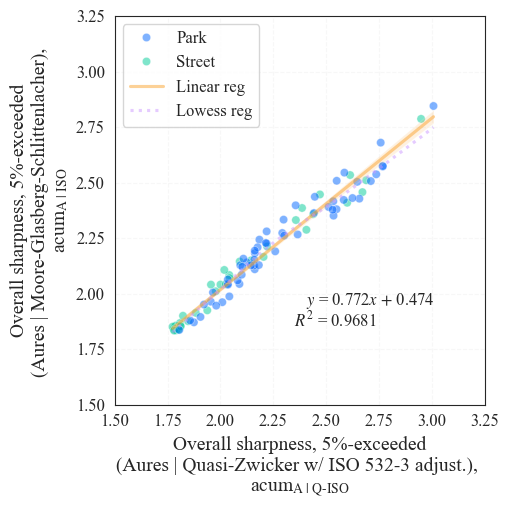

In [43]:
fig, ax = plt.subplots(figsize=(5.25, 5.25))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['SharpAurISO305ExBin'], sm.add_constant(data['SharpAurQZ532305ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='SharpAurQZ532305ExBin', y='SharpAurISO305ExBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='SharpAurQZ532305ExBin', y='SharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='SharpAurQZ532305ExBin', y='SharpAurISO305ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Moore-Glasberg-Schlittenlacher), " + "\n" + r"acum$_\text{A | ISO}$",
       xlabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker w/ ISO 532-3 adjust.), " + "\n" + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(1.5, 3.5, 0.25), xticks=np.arange(1.5, 3.5, 0.25))
ax.text(x=2.35, y=1.85, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=2.35, y=1.95,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallSAISO3vSAQZ5323"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

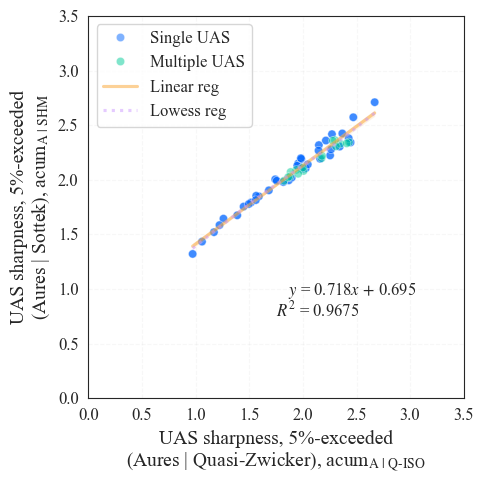

In [53]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASSharpAurSHM05ExBin'], sm.add_constant(data['UASSharpAurQZ532105ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurSHM05ExBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASSharpAurQZ532105ExBin', y='UASSharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Sottek), " + r"acum$_\text{A | SHM}$",
       xlabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker), " + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(0, 4, 0.5), xticks=np.arange(0, 4, 0.5))
ax.text(x=1.75, y=0.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=1.75, y=0.95,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatSASHMvSAQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

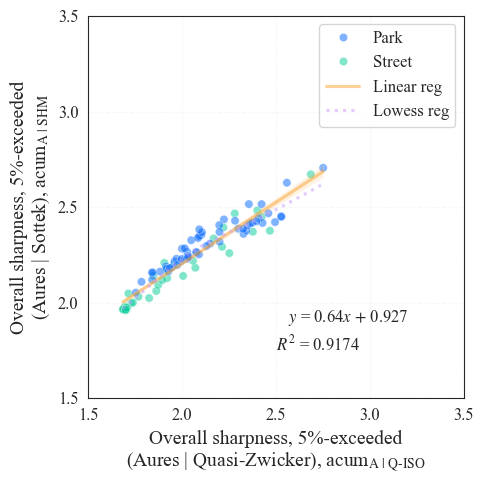

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['SharpAurSHM05ExBin'], sm.add_constant(data['SharpAurQZ532105ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurSHM05ExBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='SharpAurQZ532105ExBin', y='SharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Sottek), " + r"acum$_\text{A | SHM}$",
       xlabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker), " + r"acum$_\text{A | Q-ISO}$",
       yticks=np.arange(1.5, 4, 0.5), xticks=np.arange(1.5, 4, 0.5))
ax.text(x=2.5, y=1.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=2.5, y=1.9,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatOallSASHMvSAQZ5321"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

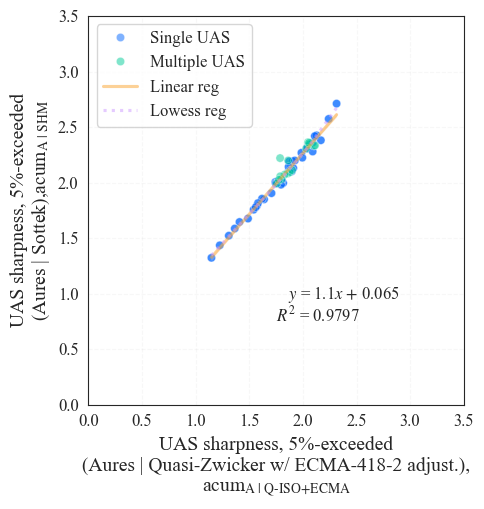

In [57]:
fig, ax = plt.subplots(figsize=(5, 5.25))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASSharpAurSHM05ExBin'], sm.add_constant(data['UASSharpAurQZ418205ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASSharpAurQZ418205ExBin', y='UASSharpAurSHM05ExBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASSharpAurQZ418205ExBin', y='UASSharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASSharpAurQZ418205ExBin', y='UASSharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Sottek)," + r"acum$_\text{A | SHM}$",
       xlabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker w/ ECMA-418-2 adjust.)," + "\n" + r"acum$_\text{A | Q-ISO+ECMA}$",
       yticks=np.arange(0, 4, 0.5), xticks=np.arange(0, 4, 0.5))
ax.text(x=1.75, y=0.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=1.75, y=0.95,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "SQscatSASHMvSAQZ4182"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

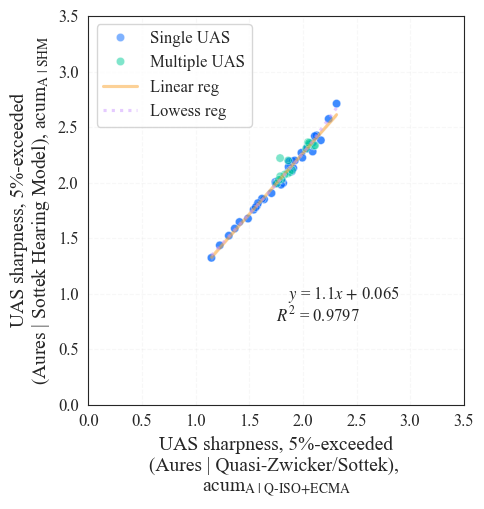

In [58]:
fig, ax = plt.subplots(figsize=(5, 5.25))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASSharpAurSHM05ExBin'], sm.add_constant(data['UASSharpAurQZ418205ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASSharpAurQZ418205ExBin', y='UASSharpAurSHM05ExBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASSharpAurQZ418205ExBin', y='UASSharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASSharpAurQZ418205ExBin', y='UASSharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Sottek Hearing Model), " + r"acum$_\text{A | SHM}$",
       xlabel="UAS sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker/Sottek), " + "\n" + r"acum$_\text{A | Q-ISO+ECMA}$",
       yticks=np.arange(0, 4, 0.5), xticks=np.arange(0, 4, 0.5))
ax.text(x=1.75, y=0.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=1.75, y=0.95,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()

if saveplots:

    filename = "FigSQscatSASHMvSAQZ4182"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

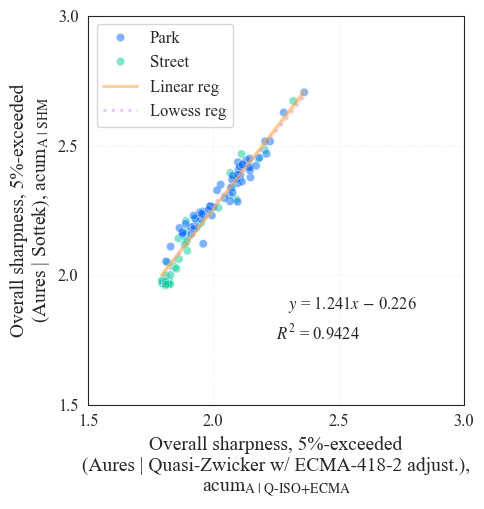

In [62]:
fig, ax = plt.subplots(figsize=(5, 5.25))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['SharpAurSHM05ExBin'], sm.add_constant(data['SharpAurQZ418205ExBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='SharpAurQZ418205ExBin', y='SharpAurSHM05ExBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='SharpAurQZ418205ExBin', y='SharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='SharpAurQZ418205ExBin', y='SharpAurSHM05ExBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Sottek), " + r"acum$_\text{A | SHM}$",
       xlabel="Overall sharpness, 5%-exceeded" + "\n" + "(Aures | Quasi-Zwicker w/ ECMA-418-2 adjust.)," + "\n" + r"acum$_\text{A | Q-ISO+ECMA}$",
       yticks=np.arange(1.5, 3.25, 0.5), xticks=np.arange(1.5, 3.25, 0.5))
ax.text(x=2.25, y=1.75, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=2.25, y=1.87,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend(loc='upper left')

if saveplots:

    filename = "SQscatOallSASHMvSAQZ4182"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

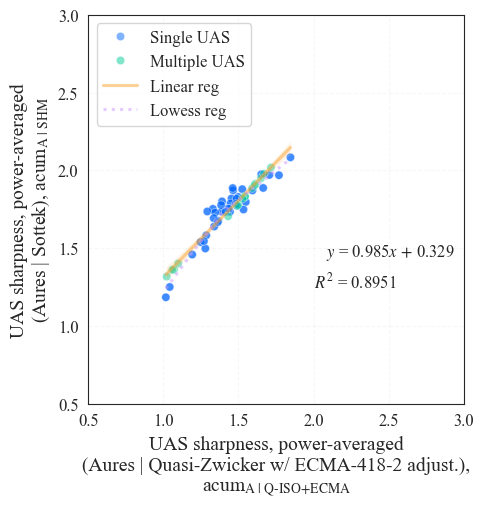

In [64]:
fig, ax = plt.subplots(figsize=(5, 5.25))

data = dataByStimTest

data = data.loc[data['UASLAeq'] != 'No UAS']

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['UASSharpAurSHMPowAvgBin'], sm.add_constant(data['UASSharpAurQZ4182PowAvgBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASSharpAurQZ4182PowAvgBin', y='UASSharpAurSHMPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASSharpAurQZ4182PowAvgBin', y='UASSharpAurSHMPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='UASSharpAurQZ4182PowAvgBin', y='UASSharpAurSHMPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="UAS sharpness, power-averaged" + "\n" + "(Aures | Sottek), " + r"acum$_\text{A | SHM}$",
       xlabel="UAS sharpness, power-averaged" + "\n" + "(Aures | Quasi-Zwicker w/ ECMA-418-2 adjust.)," + "\n" + r"acum$_\text{A | Q-ISO+ECMA}$",
       yticks=np.arange(0.5, 3.25, 0.5), xticks=np.arange(0.5, 3.25, 0.5))
ax.text(x=2., y=1.25, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=2., y=1.45,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend(loc='upper left')

if saveplots:

    filename = "SQscatSASHMvSAQZ4182PowAvg"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

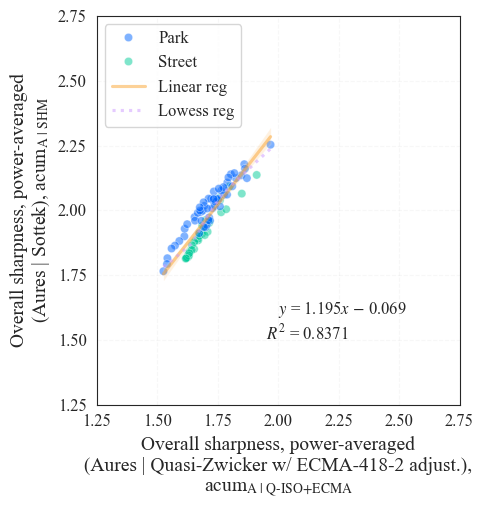

In [66]:
fig, ax = plt.subplots(figsize=(5, 5.25))

data = dataByStimTest

data = data.assign(SessionPart=data.SessionPart.map({'A': "Single UAS", 'B': "Multiple UAS"}))

# fit linear regression model 
mod = sm.OLS(data['SharpAurSHMPowAvgBin'], sm.add_constant(data['SharpAurQZ4182PowAvgBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='SharpAurQZ4182PowAvgBin', y='SharpAurSHMPowAvgBin', hue='AmbientEnv',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='SharpAurQZ4182PowAvgBin', y='SharpAurSHMPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[4], lowess=False, label="Linear reg",
            line_kws={'linestyle': '-', 'alpha': 0.5})
sns.regplot(data=data, x='SharpAurQZ4182PowAvgBin', y='SharpAurSHMPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg",
            line_kws={'linestyle': ':', 'alpha': 0.5})
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall sharpness, power-averaged" + "\n" + "(Aures | Sottek), " + r"acum$_\text{A | SHM}$",
       xlabel="Overall sharpness, power-averaged" + "\n" + "(Aures | Quasi-Zwicker w/ ECMA-418-2 adjust.)," + "\n" + r"acum$_\text{A | Q-ISO+ECMA}$",
       yticks=np.arange(1.25, 3, 0.25), xticks=np.arange(1.25, 3, 0.25))
ax.text(x=1.95, y=1.5, s=r"$R^2$ = " + str(round(res.rsquared, 4)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=1.95, y=1.6,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend(loc='upper left')

if saveplots:

    filename = "SQscatOallSASHMvSAQZ4182PowAvg"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

## Psychoacoustic annoyance analysis

Create a function to calculate psychoacoustic annoyance

In [57]:
def psychAnnoy(loudness, sharpness, roughness, fluctstr=None, tonality=None, impulsivity=None, method='widmann'):

    # initialise arrays
    omS = np.zeros(len(sharpness))
    
    if method in ['widmann', 'di', 'more', 'torija', 'willemsen']:

        if method.lower() == 'willemsen':

            pa = 27.73 + 1.24*impulsivity + 0.86*loudness*sharpness + 1.81*roughness

        else:

            omS[sharpness > 1.75] = 0.25*(sharpness[sharpness > 1.75] - 1.75)*np.log10(loudness[sharpness > 1.75] + 10)
        
            omFR = (2.18/loudness**0.4)*(0.4*fluctstr + 0.6*roughness)
            
            if method.lower() == 'widmann':
                g0 = 0
                gS = 1
                gFR = 1
                gT = 0
                gI = 0
        
                omT = 0
                omI = 0
        
            elif method.lower() == 'more':

                g0 = -0.16
                gS = 11.48
                gFR = 0.84
                gT = 1.25
                gI = 0

                omT = (1 - np.exp(-0.29*loudness))*(1 - np.exp(-5.49*tonality))
                omI = 0
            
            elif method.lower() == 'di':
                g0 = 0
                gS = 1
                gFR = 1
                gT = 1
                gI = 0

                omT = 6.41/loudness**0.52*tonality
                omI = 0

            elif method.lower() == 'torija':
                g0 = 103.08
                gS = 339.49
                gFR = 121.88
                gT = 77.2 
                gI = 29.29

                omT = (1 - np.exp(-0.29*loudness))*(1 - np.exp(-5.49*tonality))
                omI = 0.075*impulsivity/loudness**-1.334

            sqm = np.maximum(0, g0 + gS*omS**2 + gFR*omFR**2 + gT*omT**2 + gI*omI**2)

            pa = loudness*(1 + np.sqrt(sqm))

    else:
        raise ValueError("Input 'method' must be one of 'widmann', 'di', 'more', 'torija', 'willemsen'")

    return pa

In [66]:
paRMSEMean = pd.DataFrame(index=["Widmann_1", "More_1", "Di_1", "Torija_1", "Widmann_2", "More_2", "Di_2", "Torija_2"],
                              columns = ["Overall", "UAS", "Ambient", "UAS+ambient"], dtype=float)


#### Widmann psychoacoustic annoyance

In [60]:
inputSQMs = {'loudness' : 'LoudISO105ExMaxLR',
             'sharpness' : 'SharpDIN05ExBin',
             'roughness' : 'RoughFZ05ExMaxLR',
             'fluctstr' : 'FluctFZ05ExMaxLR',
             'tonality' : None,
             'impulsivity' : None}

##### Part A

In [62]:
# calculate overall psychoacoustic annoyance
paPtAWidmann_1 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                            sharpness=dataByStimTestA[inputSQMs['sharpness']],
                            roughness=dataByStimTestA[inputSQMs['roughness']],
                            fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')

panPtAWidmann_1 = pd.DataFrame(paPtAWidmann_1/paPtAWidmann_1.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [63]:
# calculate UAS only psychoacoustic annoyance
paPtAUASWidmann_1 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                               sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                               roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                               fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtAUASWidmann_1.fillna(0, inplace=True)

panPtAWidmann_1['UASMean'] = paPtAUASWidmann_1/paPtAUASWidmann_1.max()*dataByStimTestA['AnnoyMean'].max()

In [64]:
# calculate ambient only psychoacoustic annoyance
paPtAAmbWidmann_1 = psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                               sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                               roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                               fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtAAmbWidmann_1.fillna(0, inplace=True)

panPtAWidmann_1['AmbMean'] = paPtAAmbWidmann_1/paPtAAmbWidmann_1.max()*dataByStimTestA['AnnoyMean'].max()

In [65]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbWidmann_1 = np.sqrt(paPtAUASWidmann_1**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                                 sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                                 roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                                 fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                                 tonality=None,
                                                                 impulsivity=None,
                                                                 method='widmann')**2)

panPtAWidmann_1['UASAmbMean'] = paPtAUASAmbWidmann_1/paPtAUASAmbWidmann_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [67]:
# calculate overall psychoacoustic annoyance
paPtBWidmann_1 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                            sharpness=dataByStimTestB[inputSQMs['sharpness']],
                            roughness=dataByStimTestB[inputSQMs['roughness']],
                            fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')

panPtBWidmann_1 = pd.DataFrame(paPtBWidmann_1/paPtBWidmann_1.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [68]:
# calculate UAS only psychoacoustic annoyance
paPtBUASWidmann_1 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                               sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                               roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                               fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtBUASWidmann_1.fillna(0, inplace=True)

panPtBWidmann_1['UASMean'] = paPtBUASWidmann_1/paPtBUASWidmann_1.max()*dataByStimTestB['AnnoyMean'].max()

In [69]:
# calculate ambient only psychoacoustic annoyance
paPtBAmbWidmann_1 = psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                               sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                               roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                               fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtBAmbWidmann_1.fillna(0, inplace=True)

panPtBWidmann_1['AmbMean'] = paPtBAmbWidmann_1/paPtBAmbWidmann_1.max()*dataByStimTestB['AnnoyMean'].max()

In [70]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbWidmann_1 = np.sqrt(paPtBUASWidmann_1**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                                 sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                                 roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                                 fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                                 tonality=None,
                                                                 impulsivity=None,
                                                                 method='widmann')**2)

panPtBWidmann_1['UASAmbMean'] = paPtBUASAmbWidmann_1/paPtBUASAmbWidmann_1.max()*dataByStimTestB['AnnoyMean'].max()

In [71]:
datasetsAMean = [panPtAWidmann_1['OvallMean'], panPtAWidmann_1['UASMean'], panPtAWidmann_1['AmbMean'], panPtAWidmann_1['UASAmbMean']]
datasetsBMean = [panPtBWidmann_1['OvallMean'], panPtBWidmann_1['UASMean'], panPtBWidmann_1['AmbMean'], panPtBWidmann_1['UASAmbMean']]

##### Model error

In [72]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["Widmann_1", paRMSEMean.columns[ii]] = RMSE

##### Plot results

In [92]:
ii = 0
datasetA = datasetsAMean[ii]
datasetB = datasetsBMean[ii]
jj = 0

In [95]:
if ii > 1:
    iij = ii - 2
else:
    iij = ii

In [96]:
iij

0

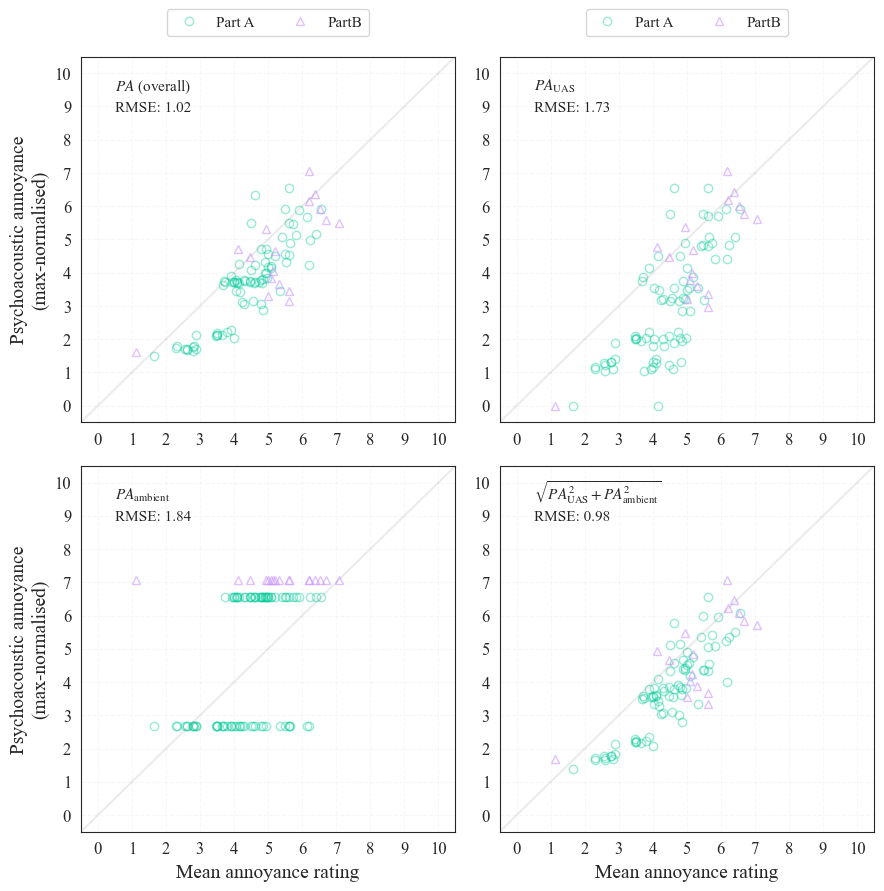

In [101]:
# plot results for Widmann model

# mean
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]

    axCoords = [(0, 0), (0, 1), (1, 0), (1, 1)][ii]
    
    axs[axCoords].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[1],
                 alpha=0.4)
    
    axs[axCoords].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[5],
                 alpha=0.6)

    axs[axCoords].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                      yticks=range(0, 11), ylim=[-0.5, 10.5])

    axs[axCoords].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[axCoords].grid(alpha=0.15, linestyle='--')

    axs[axCoords].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\it{PA}_\\text{ambient}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[axCoords].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["Widmann_1", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0 or ii == 2:
        axs[axCoords].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")

    if ii == 2 or ii == 3:
        axs[axCoords].set(xlabel="Mean annoyance rating")


    if ii == 0 or ii == 1:
        axs[axCoords].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

# if saveplots:
#     plt.savefig(os.path.join(outFigPath, "svg", "PAWidmannMean_1.svg"),
#                 format='svg')
#     plt.savefig(os.path.join(outFigPath, "pdf", "PAWidmannMean_1.pdf"),
#                 format='pdf')

plt.show()


#### More psychoacoustic annoyance

In [ ]:
inputSQMs = {'loudness' : 'LoudISO105ExMaxLR',
             'sharpness' : 'SharpvBISO105ExBin',
             'roughness' : 'RoughFZ05ExMaxLR',
             'fluctstr' : 'FluctFZ05ExMaxLR',
             'tonality' : 'TonalAur05ExMaxLR',
             'impulsivity' : None}

##### Part A

In [50]:
# calculate overall psychoacoustic annoyance
paPtAMore_1 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                           sharpness=dataByStimTestA[inputSQMs['sharpness']],
                           roughness=dataByStimTestA[inputSQMs['roughness']],
                           fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                           tonality=dataByStimTestA[inputSQMs['tonality']],
                           impulsivity=None,
                           method='more')

panPtAMore_1 = pd.DataFrame(paPtAMore_1/paPtAMore_1.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [52]:
# calculate UAS only psychoacoustic annoyance
paPtAUASMore_1 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                            sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                            roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                            fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                            tonality=dataByStimTestA["UAS" + inputSQMs['tonality']],
                            impulsivity=None,
                            method='more')
paPtAUASMore_1.fillna(0, inplace=True)

panPtAMore_1['UASMean'] = paPtAUASMore_1/paPtAUASMore_1.max()*dataByStimTestA['AnnoyMean'].max()

In [53]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbMore_1 = np.sqrt(paPtAUASMore_1**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                           sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                           roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                           fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                           tonality=dataByStimTestA["Amb" + inputSQMs['tonality']],
                                                           impulsivity=None,
                                                          method='more')**2)

panPtAMore_1['UASAmbMean'] = paPtAUASAmbMore_1/paPtAUASAmbMore_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [54]:
# calculate overall psychoacoustic annoyance
paPtBMore_1 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                         sharpness=dataByStimTestB[inputSQMs['sharpness']],
                         roughness=dataByStimTestB[inputSQMs['roughness']],
                         fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                         tonality=dataByStimTestB[inputSQMs['tonality']],
                         impulsivity=None,
                         method='more')

panPtBMore_1 = pd.DataFrame(paPtBMore_1/paPtBMore_1.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [55]:
# calculate UAS only psychoacoustic annoyance
paPtBUASMore_1 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                            sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                            roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                            fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                            tonality=dataByStimTestB["UAS" + inputSQMs['tonality']],
                            impulsivity=None,
                            method='more')
paPtBUASMore_1.fillna(0, inplace=True)

panPtBMore_1['UASMean'] = paPtBUASMore_1/paPtBUASMore_1.max()*dataByStimTestB['AnnoyMean'].max()

In [56]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbMore_1 = np.sqrt(paPtBUASMore_1**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                           sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                           roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                           fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                           tonality=dataByStimTestB["Amb" + inputSQMs['tonality']],
                                                           impulsivity=None,
                                                           method='more')**2)

panPtBMore_1['UASAmbMean'] = paPtBUASAmbMore_1/paPtBUASAmbMore_1.max()*dataByStimTestB['AnnoyMean'].max()

In [57]:
datasetsAMean = [panPtAMore_1['OvallMean'], panPtAMore_1['UASMean'], panPtAMore_1['UASAmbMean']]
datasetsBMean = [panPtBMore_1['OvallMean'], panPtBMore_1['UASMean'], panPtBMore_1['UASAmbMean']]


##### Model error

In [58]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["More_1", paRMSEMean.columns[ii]] = RMSE

##### Plot results

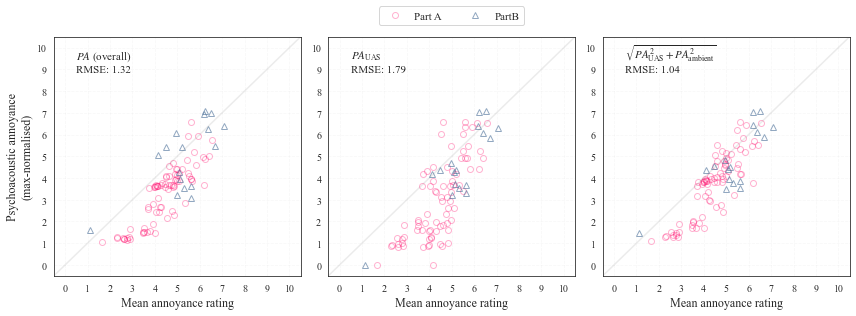

In [59]:
# plot results for More model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[3],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["More_1", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")

    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PAMoreMean_1.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PAMoreMean_1.pdf"),
                format='pdf')

plt.show()


#### Di psychoacoustic annoyance

In [ ]:
inputSQMs = {'loudness' : 'LoudISO105ExMaxLR',
             'sharpness' : 'SharpvBISO105ExBin',
             'roughness' : 'RoughFZ05ExMaxLR',
             'fluctstr' : 'FluctFZ05ExMaxLR',
             'tonality' : 'TonalAur05ExMaxLR',
             'impulsivity' : None}

##### Part A

In [61]:
# calculate overall psychoacoustic annoyance
paPtADi_1 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                       sharpness=dataByStimTestA[inputSQMs['sharpness']],
                       roughness=dataByStimTestA[inputSQMs['roughness']],
                       fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                       tonality=dataByStimTestA[inputSQMs['tonality']],
                       impulsivity=None,
                       method='di')

panPtADi_1 = pd.DataFrame(paPtADi_1/paPtADi_1.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [64]:
# calculate UAS only psychoacoustic annoyance
paPtAUASDi_1 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                          sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                          roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                          fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                          tonality=dataByStimTestA["UAS" + inputSQMs['tonality']],
                          impulsivity=None,
                          method='di')
paPtAUASDi_1.fillna(0, inplace=True)

panPtADi_1['UASMean'] = paPtAUASDi_1/paPtAUASDi_1.max()*dataByStimTestA['AnnoyMean'].max()

In [63]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbDi_1 = np.sqrt(paPtAUASDi_1**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                       sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                       roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                       fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                       tonality=dataByStimTestA["Amb" + inputSQMs['tonality']],
                                                       impulsivity=None,
                                                       method='di')**2)

panPtADi_1['UASAmbMean'] = paPtAUASAmbDi_1/paPtAUASAmbDi_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [65]:
# calculate overall psychoacoustic annoyance
paPtBDi_1 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                       sharpness=dataByStimTestB[inputSQMs['sharpness']],
                       roughness=dataByStimTestB[inputSQMs['roughness']],
                       fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                       tonality=dataByStimTestB[inputSQMs['tonality']],
                       impulsivity=None,
                       method='di')

panPtBDi_1 = pd.DataFrame(paPtBDi_1/paPtBDi_1.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [66]:
# calculate UAS only psychoacoustic annoyance
paPtBUASDi_1 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                          sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                          roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                          fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                          tonality=dataByStimTestB["UAS" + inputSQMs['tonality']],
                          impulsivity=None,
                          method='di')
paPtBUASDi_1.fillna(0, inplace=True)

panPtBDi_1['UASMean'] = paPtBUASDi_1/paPtBUASDi_1.max()*dataByStimTestB['AnnoyMean'].max()

In [67]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbDi_1 = np.sqrt(paPtBUASDi_1**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                       sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                       roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                       fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                       tonality=dataByStimTestB["Amb" + inputSQMs['tonality']],
                                                       impulsivity=None,
                                                       method='di')**2)

panPtBDi_1['UASAmbMean'] = paPtBUASAmbDi_1/paPtBUASAmbDi_1.max()*dataByStimTestB['AnnoyMean'].max()

In [68]:
datasetsAMean = [panPtADi_1['OvallMean'], panPtADi_1['UASMean'], panPtADi_1['UASAmbMean']]
datasetsBMean = [panPtBDi_1['OvallMean'], panPtBDi_1['UASMean'], panPtBDi_1['UASAmbMean']]


##### Model error

In [69]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["Di_1", paRMSEMean.columns[ii]] = RMSE

##### Plot results

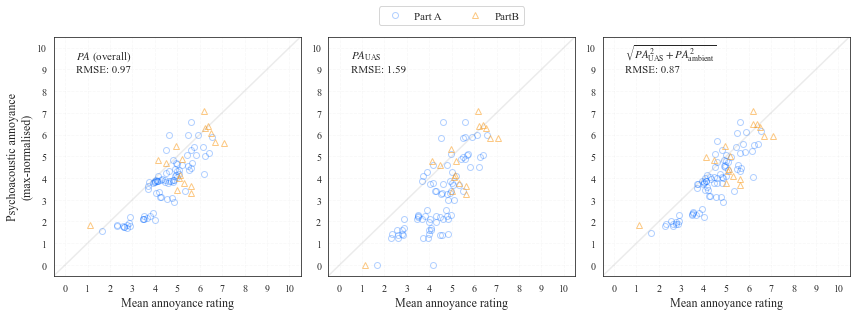

In [70]:
# plot results for Di model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[0],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["Di_1", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PADiMean_1.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PADiMean_1.pdf"),
                format='pdf')

plt.show()


#### Torija psychoacoustic annoyance

In [12]:
inputSQMs = {'loudness' : 'LoudISO105ExMaxLR',
             'sharpness' : 'SharpDIN05ExBin',
             'roughness' : 'RoughECMA05ExBin',
             'fluctstr' : 'FluctOldSHM05ExBin',
             'tonality' : 'TonalAur05ExMaxLR',
             'impulsivity' : 'ImpulsSHM05ExMaxLR'}

##### Part A

In [13]:
# calculate overall psychoacoustic annoyance
paPtATorija_1 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                           sharpness=dataByStimTestA[inputSQMs['sharpness']],
                           roughness=dataByStimTestA[inputSQMs['roughness']],
                           fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                           tonality=dataByStimTestA[inputSQMs['tonality']],
                           impulsivity=dataByStimTestA[inputSQMs['impulsivity']],
                           method='torija')

panPtATorija_1 = pd.DataFrame(paPtATorija_1/paPtATorija_1.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [196]:
# calculate UAS only psychoacoustic annoyance
paPtAUASTorija_1 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                              sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                              roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                              fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                              tonality=dataByStimTestA["UAS" + inputSQMs['tonality']],
                              impulsivity=dataByStimTestA["UAS" + inputSQMs['impulsivity']],
                              method='torija')
paPtAUASTorija_1.fillna(0, inplace=True)

panPtATorija_1['UASMean'] = paPtAUASTorija_1/paPtAUASTorija_1.max()*dataByStimTestA['AnnoyMean'].max()

In [197]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbTorija_1 = np.sqrt(paPtAUASTorija_1**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                               sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                               roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                               fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                               tonality=dataByStimTestA["Amb" + inputSQMs['tonality']],
                                                               impulsivity=dataByStimTestA["Amb" + inputSQMs['impulsivity']],
                                                               method='torija')**2)

panPtATorija_1['UASAmbMean'] = paPtAUASAmbTorija_1/paPtAUASAmbTorija_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [200]:
# calculate overall psychoacoustic annoyance
paPtBTorija_1 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                           sharpness=dataByStimTestB[inputSQMs['sharpness']],
                           roughness=dataByStimTestB[inputSQMs['roughness']],
                           fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                           tonality=dataByStimTestB[inputSQMs['tonality']],
                           impulsivity=dataByStimTestB[inputSQMs['impulsivity']],
                           method='torija')

panPtBTorija_1 = pd.DataFrame(paPtBTorija_1/paPtBTorija_1.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [201]:
# calculate UAS only psychoacoustic annoyance
paPtBUASTorija_1 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                              sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                              roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                              fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                              tonality=dataByStimTestB["UAS" + inputSQMs['tonality']],
                              impulsivity=dataByStimTestB["UAS" + inputSQMs['impulsivity']],
                              method='torija')
paPtBUASTorija_1.fillna(0, inplace=True)

panPtBTorija_1['UASMean'] = paPtBUASTorija_1/paPtBUASTorija_1.max()*dataByStimTestB['AnnoyMean'].max()

In [202]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbTorija_1 = np.sqrt(paPtBUASTorija_1**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                               sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                               roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                               fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                               tonality=dataByStimTestB["Amb" + inputSQMs['tonality']],
                                                               impulsivity=dataByStimTestB["Amb" + inputSQMs['impulsivity']],
                                                               method='torija')**2)

panPtBTorija_1['UASAmbMean'] = paPtBUASAmbTorija_1/paPtBUASAmbTorija_1.max()*dataByStimTestB['AnnoyMean'].max()

In [203]:
datasetsAMean = [panPtATorija_1['OvallMean'], panPtATorija_1['UASMean'], panPtATorija_1['UASAmbMean']]
datasetsBMean = [panPtBTorija_1['OvallMean'], panPtBTorija_1['UASMean'], panPtBTorija_1['UASAmbMean']]


##### Model error

In [204]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["Torija_1", paRMSEMean.columns[ii]] = RMSE

##### Plot results

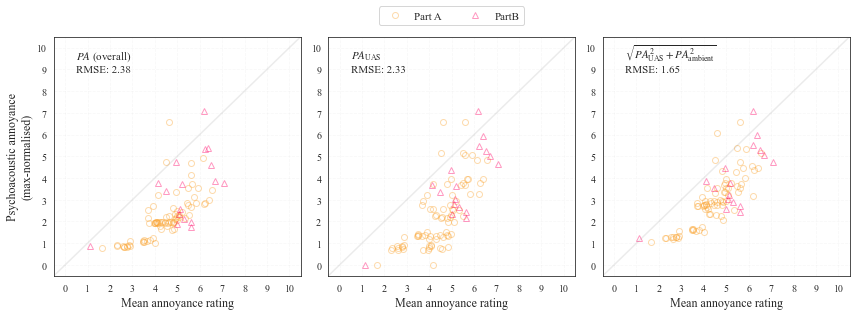

In [205]:
# plot results for Torija model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.4)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.4)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["Torija_1", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PATorijaMean_1.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PATorijaMean_1.pdf"),
                format='pdf')

plt.show()


#### Widmann psychoacoustic annoyance with new input metrics

In [ ]:
inputSQMs = {'loudness' : 'LoudECMAPowAvgBin',
             'sharpness' : 'SharpAurISO305ExBin',
             'roughness' : 'RoughFZ05ExMaxLR',
             'fluctstr' : 'FluctOV10ExMaxLR',
             'tonality' : None,
             'impulsivity' : None}

##### Part A

In [90]:
# calculate overall psychoacoustic annoyance
paPtAWidmann_2 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                            sharpness=dataByStimTestA[inputSQMs['sharpness']],
                            roughness=dataByStimTestA[inputSQMs['roughness']],
                            fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')

panPtAWidmann_2 = pd.DataFrame(paPtAWidmann_2/paPtAWidmann_2.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [91]:
# calculate UAS only psychoacoustic annoyance
paPtAUASWidmann_2 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                               sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                               roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                               fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtAUASWidmann_2.fillna(0, inplace=True)

panPtAWidmann_2['UASMean'] = paPtAUASWidmann_2/paPtAUASWidmann_2.max()*dataByStimTestA['AnnoyMean'].max()

In [92]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbWidmann_2 = np.sqrt(paPtAUASWidmann_2**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                                 sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                                 roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                                 fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                                 tonality=None,
                                                                 impulsivity=None,
                                                                 method='widmann')**2)

panPtAWidmann_2['UASAmbMean'] = paPtAUASAmbWidmann_2/paPtAUASAmbWidmann_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [93]:
# calculate overall psychoacoustic annoyance
paPtBWidmann_2 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                            sharpness=dataByStimTestB[inputSQMs['sharpness']],
                            roughness=dataByStimTestB[inputSQMs['roughness']],
                            fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')

panPtBWidmann_2 = pd.DataFrame(paPtBWidmann_2/paPtBWidmann_2.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [94]:
# calculate UAS only psychoacoustic annoyance
paPtBUASWidmann_2 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                               sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                               roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                               fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtBUASWidmann_2.fillna(0, inplace=True)

panPtBWidmann_2['UASMean'] = paPtBUASWidmann_2/paPtBUASWidmann_2.max()*dataByStimTestB['AnnoyMean'].max()

In [95]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbWidmann_2 = np.sqrt(paPtBUASWidmann_2**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                                 sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                                 roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                                 fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                                 tonality=None,
                                                                 impulsivity=None,
                                                                 method='widmann')**2)

panPtBWidmann_2['UASAmbMean'] = paPtBUASAmbWidmann_2/paPtBUASAmbWidmann_2.max()*dataByStimTestB['AnnoyMean'].max()

In [96]:
datasetsAMean = [panPtAWidmann_2['OvallMean'], panPtAWidmann_2['UASMean'], panPtAWidmann_2['UASAmbMean']]
datasetsBMean = [panPtBWidmann_2['OvallMean'], panPtBWidmann_2['UASMean'], panPtBWidmann_2['UASAmbMean']]

##### Model error

In [97]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["Widmann_2", paRMSEMean.columns[ii]] = RMSE

##### Plot results

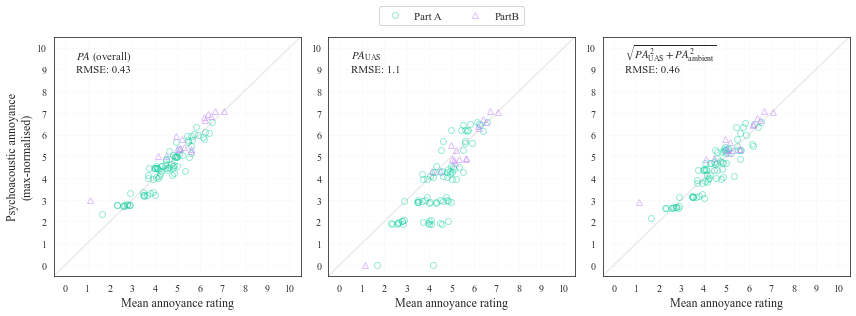

In [98]:
# plot results for Widmann model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[1],
                 alpha=0.4)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[5],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["Widmann_2", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PAWidmannMean_2.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PAWidmannMean_2.pdf"),
                format='pdf')

plt.show()


#### More psychoacoustic annoyance with new input metrics

In [ ]:
inputSQMs = {'loudness' : 'LoudECMAPowAvgBin',
             'sharpness' : 'SharpAurISO305ExBin',
             'roughness' : 'RoughFZ05ExMaxLR',
             'fluctstr' : 'FluctOV10ExMaxLR',
             'tonality' : 'TonalSHMInt05ExMaxLR',
             'impulsivity' : None}

##### Part A

In [100]:
# calculate overall psychoacoustic annoyance
paPtAMore_2 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                         sharpness=dataByStimTestA[inputSQMs['sharpness']],
                         roughness=dataByStimTestA[inputSQMs['roughness']],
                         fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                         tonality=dataByStimTestA[inputSQMs['tonality']],
                         impulsivity=None,
                         method='more')

panPtAMore_2 = pd.DataFrame(paPtAMore_2/paPtAMore_2.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [101]:
# calculate UAS only psychoacoustic annoyance
paPtAUASMore_2 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                            sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                            roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                            fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                            tonality=dataByStimTestA["UAS" + inputSQMs['tonality']],
                            impulsivity=None,
                            method='more')
paPtAUASMore_2.fillna(0, inplace=True)

panPtAMore_2['UASMean'] = paPtAUASMore_2/paPtAUASMore_2.max()*dataByStimTestA['AnnoyMean'].max()

In [102]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbMore_2 = np.sqrt(paPtAUASMore_2**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                           sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                           roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                           fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                           tonality=dataByStimTestA["Amb" + inputSQMs['tonality']],
                                                           impulsivity=None,
                                                           method='more')**2)

panPtAMore_2['UASAmbMean'] = paPtAUASAmbMore_2/paPtAUASAmbMore_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [103]:
# calculate overall psychoacoustic annoyance
paPtBMore_2 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                         sharpness=dataByStimTestB[inputSQMs['sharpness']],
                         roughness=dataByStimTestB[inputSQMs['roughness']],
                         fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                         tonality=dataByStimTestB[inputSQMs['tonality']],
                         impulsivity=None,
                         method='more')

panPtBMore_2 = pd.DataFrame(paPtBMore_2/paPtBMore_2.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [104]:
# calculate UAS only psychoacoustic annoyance
paPtBUASMore_2 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                            sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                            roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                            fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                            tonality=dataByStimTestB["UAS" + inputSQMs['tonality']],
                            impulsivity=None,
                            method='more')
paPtBUASMore_2.fillna(0, inplace=True)

panPtBMore_2['UASMean'] = paPtBUASMore_2/paPtBUASMore_2.max()*dataByStimTestB['AnnoyMean'].max()

In [107]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbMore_2 = np.sqrt(paPtBUASMore_2**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                           sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                           roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                           fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                           tonality=dataByStimTestB["Amb" + inputSQMs['tonality']],
                                                           impulsivity=None,
                                                           method='more')**2)

panPtBMore_2['UASAmbMean'] = paPtBUASAmbMore_2/paPtBUASAmbMore_2.max()*dataByStimTestB['AnnoyMean'].max()

In [106]:
datasetsAMean = [panPtAMore_2['OvallMean'], panPtAMore_2['UASMean'], panPtAMore_2['UASAmbMean']]
datasetsBMean = [panPtBMore_2['OvallMean'], panPtBMore_2['UASMean'], panPtBMore_2['UASAmbMean']]


##### Model error

In [108]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["More_2", paRMSEMean.columns[ii]] = RMSE

##### Plot results

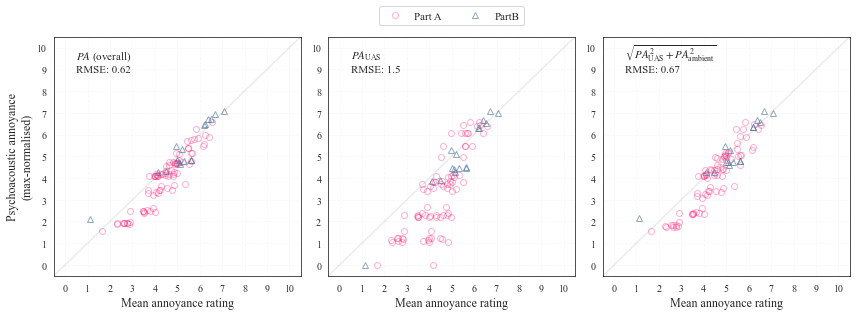

In [109]:
# plot results for More model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[3],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["More_2", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PAMoreMean_2.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PAMoreMean_2.pdf"),
                format='pdf')

plt.show()


#### Di psychoacoustic annoyance with new input metrics

In [ ]:
inputSQMs = {'loudness' : 'LoudECMAPowAvgBin',
             'sharpness' : 'SharpAurISO305ExBin',
             'roughness' : 'RoughFZ05ExMaxLR',
             'fluctstr' : 'FluctOV10ExMaxLR',
             'tonality' : 'TonalSHMInt05ExMaxLR',
             'impulsivity' : None}

##### Part A

In [224]:
# calculate overall psychoacoustic annoyance
paPtADi_2 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                       sharpness=dataByStimTestA[inputSQMs['sharpness']],
                       roughness=dataByStimTestA[inputSQMs['roughness']],
                       fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                       tonality=dataByStimTestA[inputSQMs['tonality']],
                       impulsivity=None,
                       method='di')

panPtADi_2 = pd.DataFrame(paPtADi_2/paPtADi_2.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [225]:
# calculate UAS only psychoacoustic annoyance
paPtAUASDi_2 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                          sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                          roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                          fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                          tonality=dataByStimTestA["UAS" + inputSQMs['tonality']],
                          impulsivity=None,
                          method='di')
paPtAUASDi_2.fillna(0, inplace=True)

panPtADi_2['UASMean'] = paPtAUASDi_2/paPtAUASDi_2.max()*dataByStimTestA['AnnoyMean'].max()

In [226]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbDi_2 = np.sqrt(paPtAUASDi_2**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                       sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                       roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                       fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                       tonality=dataByStimTestA["Amb" + inputSQMs['tonality']],
                                                       impulsivity=None,
                                                       method='di')**2)

panPtADi_2['UASAmbMean'] = paPtAUASAmbDi_2/paPtAUASAmbDi_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [227]:
# calculate overall psychoacoustic annoyance
paPtBDi_2 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                       sharpness=dataByStimTestB[inputSQMs['sharpness']],
                       roughness=dataByStimTestB[inputSQMs['roughness']],
                       fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                       tonality=dataByStimTestB[inputSQMs['tonality']],
                       impulsivity=None,
                       method='di')

panPtBDi_2 = pd.DataFrame(paPtBDi_2/paPtBDi_2.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [228]:
# calculate UAS only psychoacoustic annoyance
paPtBUASDi_2 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                          sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                          roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                          fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                          tonality=dataByStimTestB["UAS" + inputSQMs['tonality']],
                          impulsivity=None,
                          method='di')
paPtBUASDi_2.fillna(0, inplace=True)

panPtBDi_2['UASMean'] = paPtBUASDi_2/paPtBUASDi_2.max()*dataByStimTestB['AnnoyMean'].max()

In [229]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbDi_2 = np.sqrt(paPtBUASDi_2**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                       sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                       roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                       fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                       tonality=dataByStimTestB["Amb" + inputSQMs['tonality']],
                                                       impulsivity=None,
                                                       method='di')**2)

panPtBDi_2['UASAmbMean'] = paPtBUASAmbDi_2/paPtBUASAmbDi_2.max()*dataByStimTestB['AnnoyMean'].max()

In [230]:
datasetsAMean = [panPtADi_2['OvallMean'], panPtADi_2['UASMean'], panPtADi_2['UASAmbMean']]
datasetsBMean = [panPtBDi_2['OvallMean'], panPtBDi_2['UASMean'], panPtBDi_2['UASAmbMean']]


##### Model error

In [231]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["Di_2", paRMSEMean.columns[ii]] = RMSE

##### Plot results

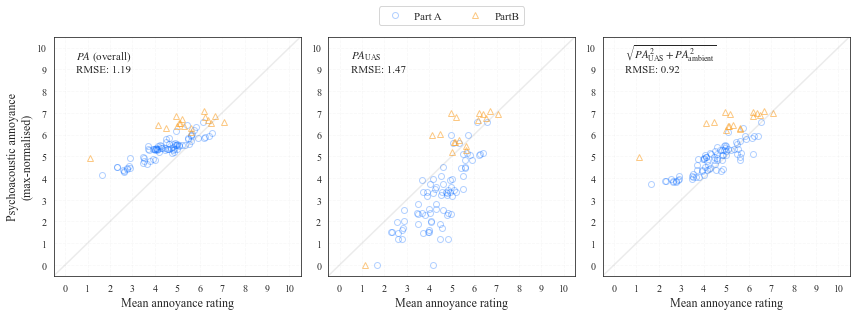

In [232]:
# plot results for Di model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[0],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["Di_2", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")

    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PADiMean_2.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PADiMean_2.pdf"),
                format='pdf')

plt.show()


#### Torija psychoacoustic annoyance with new input metrics

In [ ]:
inputSQMs = {'loudness' : 'LoudECMAPowAvgBin',
             'sharpness' : 'SharpAurISO305ExBin',
             'roughness' : 'RoughFZ05ExMaxLR',
             'fluctstr' : 'FluctOV10ExMaxLR',
             'tonality' : 'TonalSHMInt05ExMaxLR',
             'impulsivity' : 'ImpulsSHMAvgMaxLR'}

##### Part A

In [207]:
# calculate overall psychoacoustic annoyance
paPtATorija_2 = psychAnnoy(loudness=dataByStimTestA[inputSQMs['loudness']],
                           sharpness=dataByStimTestA[inputSQMs['sharpness']],
                           roughness=dataByStimTestA[inputSQMs['roughness']],
                           fluctstr=dataByStimTestA[inputSQMs['fluctstr']],
                           tonality=dataByStimTestA[inputSQMs['tonality']],
                           impulsivity=dataByStimTestA[inputSQMs['impulsivity']],
                           method='torija')

panPtATorija_2 = pd.DataFrame(paPtATorija_2/paPtATorija_2.max()*dataByStimTestA['AnnoyMean'].max(), columns=['OvallMean'])

In [208]:
# calculate UAS only psychoacoustic annoyance
paPtAUASTorija_2 = psychAnnoy(loudness=dataByStimTestA["UAS" + inputSQMs['loudness']],
                              sharpness=dataByStimTestA["UAS" + inputSQMs['sharpness']],
                              roughness=dataByStimTestA["UAS" + inputSQMs['roughness']],
                              fluctstr=dataByStimTestA["UAS" + inputSQMs['fluctstr']],
                              tonality=dataByStimTestA["UAS" + inputSQMs['tonality']],
                              impulsivity=dataByStimTestA["UAS" + inputSQMs['impulsivity']],
                              method='torija')
paPtAUASTorija_2.fillna(0, inplace=True)

panPtATorija_2['UASMean'] = paPtAUASTorija_2/paPtAUASTorija_2.max()*dataByStimTestA['AnnoyMean'].max()

In [209]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbTorija_2 = np.sqrt(paPtAUASTorija_2**2 + psychAnnoy(loudness=dataByStimTestA["Amb" + inputSQMs['loudness']],
                                                               sharpness=dataByStimTestA["Amb" + inputSQMs['sharpness']],
                                                               roughness=dataByStimTestA["Amb" + inputSQMs['roughness']],
                                                               fluctstr=dataByStimTestA["Amb" + inputSQMs['fluctstr']],
                                                               tonality=dataByStimTestA["Amb" + inputSQMs['tonality']],
                                                               impulsivity=dataByStimTestA["Amb" + inputSQMs['impulsivity']],
                                                               method='torija')**2)

panPtATorija_2['UASAmbMean'] = paPtAUASAmbTorija_2/paPtAUASAmbTorija_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [210]:
# calculate overall psychoacoustic annoyance
paPtBTorija_2 = psychAnnoy(loudness=dataByStimTestB[inputSQMs['loudness']],
                           sharpness=dataByStimTestB[inputSQMs['sharpness']],
                           roughness=dataByStimTestB[inputSQMs['roughness']],
                           fluctstr=dataByStimTestB[inputSQMs['fluctstr']],
                           tonality=dataByStimTestB[inputSQMs['tonality']],
                           impulsivity=dataByStimTestB[inputSQMs['impulsivity']],
                           method='torija')

panPtBTorija_2 = pd.DataFrame(paPtBTorija_2/paPtBTorija_2.max()*dataByStimTestB['AnnoyMean'].max(), columns=['OvallMean'])

In [211]:
# calculate UAS only psychoacoustic annoyance
paPtBUASTorija_2 = psychAnnoy(loudness=dataByStimTestB["UAS" + inputSQMs['loudness']],
                              sharpness=dataByStimTestB["UAS" + inputSQMs['sharpness']],
                              roughness=dataByStimTestB["UAS" + inputSQMs['roughness']],
                              fluctstr=dataByStimTestB["UAS" + inputSQMs['fluctstr']],
                              tonality=dataByStimTestB["UAS" + inputSQMs['tonality']],
                              impulsivity=dataByStimTestB["UAS" + inputSQMs['impulsivity']],
                              method='torija')
paPtBUASTorija_2.fillna(0, inplace=True)

panPtBTorija_2['UASMean'] = paPtBUASTorija_2/paPtBUASTorija_2.max()*dataByStimTestB['AnnoyMean'].max()

In [212]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbTorija_2 = np.sqrt(paPtBUASTorija_2**2 + psychAnnoy(loudness=dataByStimTestB["Amb" + inputSQMs['loudness']],
                                                               sharpness=dataByStimTestB["Amb" + inputSQMs['sharpness']],
                                                               roughness=dataByStimTestB["Amb" + inputSQMs['roughness']],
                                                               fluctstr=dataByStimTestB["Amb" + inputSQMs['fluctstr']],
                                                               tonality=dataByStimTestB["Amb" + inputSQMs['tonality']],
                                                               impulsivity=dataByStimTestB["Amb" + inputSQMs['impulsivity']],
                                                               method='torija')**2)

panPtBTorija_2['UASAmbMean'] = paPtBUASAmbTorija_2/paPtBUASAmbTorija_2.max()*dataByStimTestB['AnnoyMean'].max()

In [213]:
datasetsAMean = [panPtATorija_2['OvallMean'], panPtATorija_2['UASMean'], panPtATorija_2['UASAmbMean']]
datasetsBMean = [panPtBTorija_2['OvallMean'], panPtBTorija_2['UASMean'], panPtBTorija_2['UASAmbMean']]


##### Model error

In [214]:
# calculate RMSE

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    paRMSEMean.loc["Torija_2", paRMSEMean.columns[ii]] = RMSE

##### Plot results

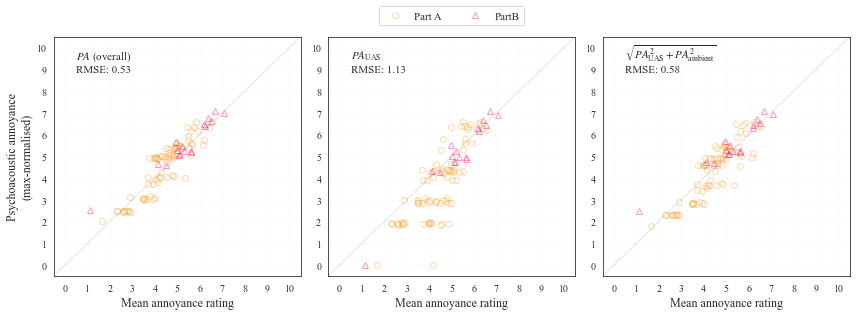

In [215]:
# plot results for Torija model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate(datasetsAMean):
    
    datasetB = datasetsBMean[ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.4)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.4)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.1)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["$\\it{PA}$ (overall)", "$\\it{PA}_\\text{UAS}$", "$\\sqrt{\\it{PA}_\\text{UAS}^2 + \\it{PA}_\\text{ambient}^2}$"][ii], fontsize=11)

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(paRMSEMean.loc["Torija_2", paRMSEMean.columns[ii]], 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PATorijaMean_2.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PATorijaMean_2.pdf"),
                format='pdf')

plt.show()


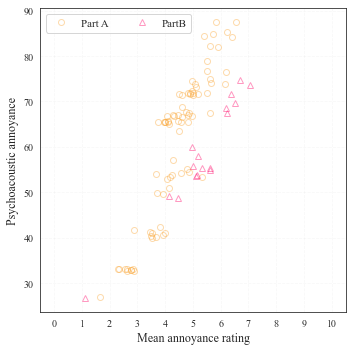

In [216]:
# plot results for Torija model

fig, ax = plt.subplots(figsize=(5, 5))
    
ax.plot(dataByStimTestA['AnnoyMean'], paPtATorija_2, linestyle='None',
             marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
             alpha=0.4)

ax.plot(dataByStimTestB['AnnoyMean'], paPtBTorija_2, linestyle='None',
             marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
             alpha=0.4)

ax.set(xticks=range(0, 11), xlim=[-0.5, 10.5],
            xlabel="Mean annoyance rating")

ax.grid(alpha=0.15, linestyle='--')

ax.set(ylabel="Psychoacoustic annoyance")


ax.legend(labels=['Part A', 'PartB'], ncol=2, fontsize=11)

plt.show()


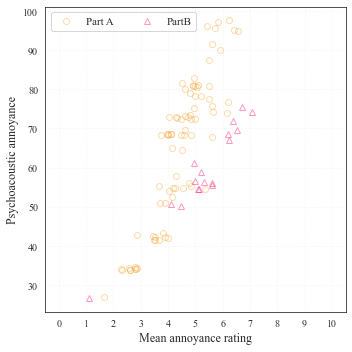

In [217]:
# plot results for Torija model

fig, ax = plt.subplots(figsize=(5, 5))
    
ax.plot(dataByStimTestA['AnnoyMean'], paPtAUASAmbTorija_2, linestyle='None',
             marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
             alpha=0.4)

ax.plot(dataByStimTestB['AnnoyMean'], paPtBUASAmbTorija_2, linestyle='None',
             marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
             alpha=0.4)

ax.set(xticks=range(0, 11), xlim=[-0.5, 10.5],
            xlabel="Mean annoyance rating")

ax.grid(alpha=0.15, linestyle='--')

ax.set(ylabel="Psychoacoustic annoyance")


ax.legend(labels=['Part A', 'PartB'], ncol=2, fontsize=11)

plt.show()


## Correlations between UAS SQMs

### Annoyance

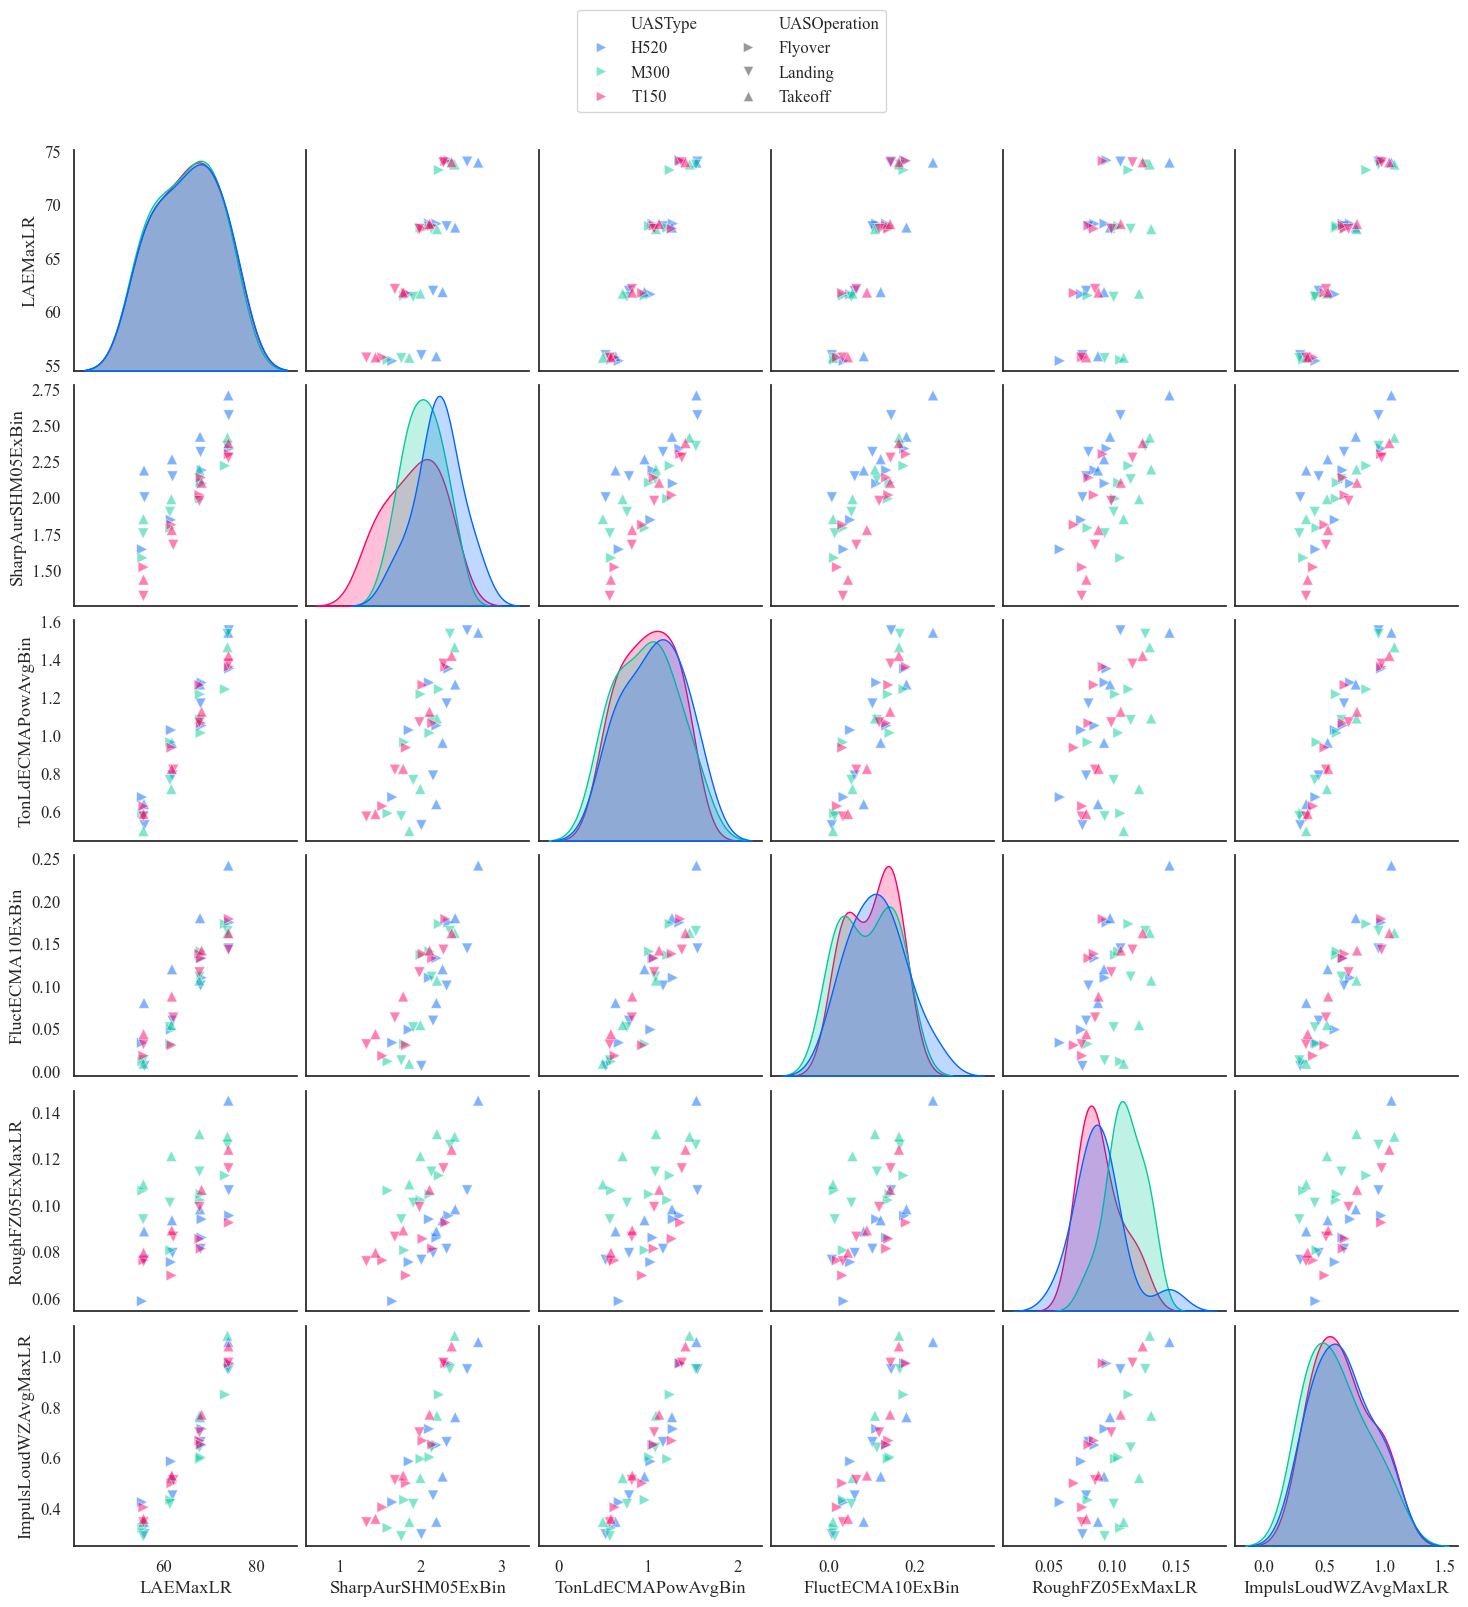

In [ ]:
# pairwise plots for absolute SQMs influencing mean change in annoyance
# using auxData to avoid data duplication, SQMs do not need 'UAS' prefix
metrics = ["LAEMaxLR", "SharpAurSHM05ExBin", "TonLdECMAPowAvgBin",
           "FluctECMA10ExBin", "RoughFZ05ExMaxLR", "ImpulsLoudWZAvgMaxLR"]

map_to_marker = {'Takeoff': '^', 'Overflight': '>', 'Landing': 'v'}

scatter_kws = {'s': 60, 'alpha': 0.5, 'style': auxData['UASOperation'],  'markers': map_to_marker}

sns.set_theme(style='white', font_scale=1.1, font='serif')

pplot = sns.pairplot(data=auxData.loc[auxData['SessionPart']=="A", :],
                     hue="UASType", palette=mycolours[0:3], vars=metrics,
                     corner=False, plot_kws=scatter_kws)


sns.move_legend(
    pplot, loc="upper center", bbox_to_anchor=(0.45, 1.08), title=None, frameon=True, ncols=2
)

filename = "PtASQMdAnnoyPairwise"

if saveplots:
    pplot.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                    format='svg')
    pplot.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                    format='pdf')


sns.set_theme(style='white', font_scale=1)


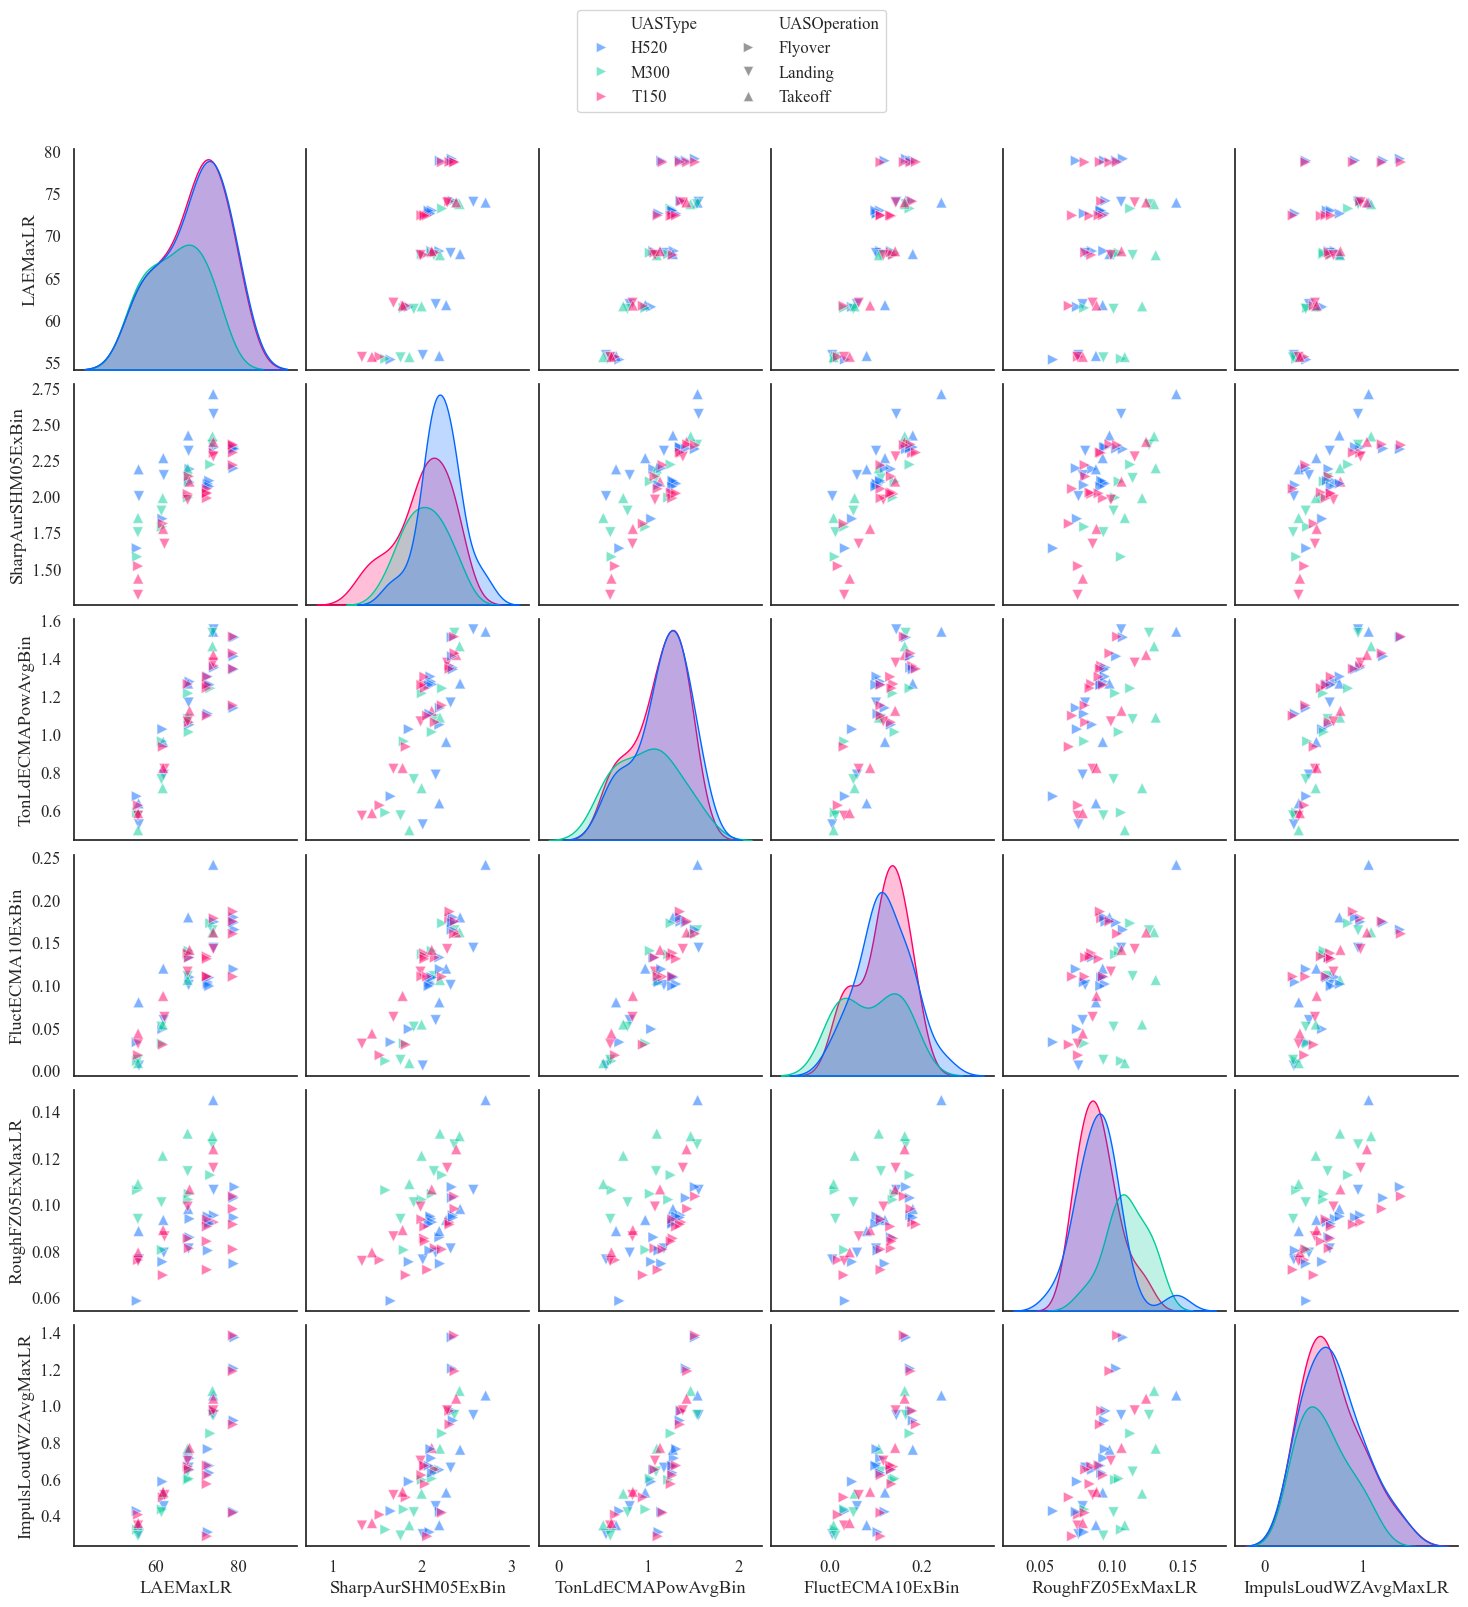

In [ ]:
# pairwise plots for absolute SQMs influencing mean change in annoyance
# using auxData to avoid data duplication, SQMs do not need 'UAS' prefix
metrics = ["LAEMaxLR", "SharpAurSHM05ExBin", "TonLdECMAPowAvgBin",
           "FluctECMA10ExBin", "RoughFZ05ExMaxLR", "ImpulsLoudWZAvgMaxLR"]

map_to_marker = {'Takeoff': '^', 'Overflight': '>', 'Landing': 'v'}

scatter_kws = {'s': 60, 'alpha': 0.5, 'style': auxData['UASOperation'],  'markers': map_to_marker}

sns.set_theme(style='white', font_scale=1.1, font='serif')

pplot = sns.pairplot(data=auxData,
                     hue="UASType", palette=mycolours[0:3], vars=metrics,
                     corner=False, plot_kws=scatter_kws)

sns.move_legend(
    pplot, loc="upper center", bbox_to_anchor=(0.45, 1.08), title=None, frameon=True, ncols=2
)

filename = "PtsABSQMdAnnoyPairwise"

if saveplots:
    pplot.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                    format='svg')
    pplot.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                    format='pdf')


sns.set_theme(style='white', font_scale=1)


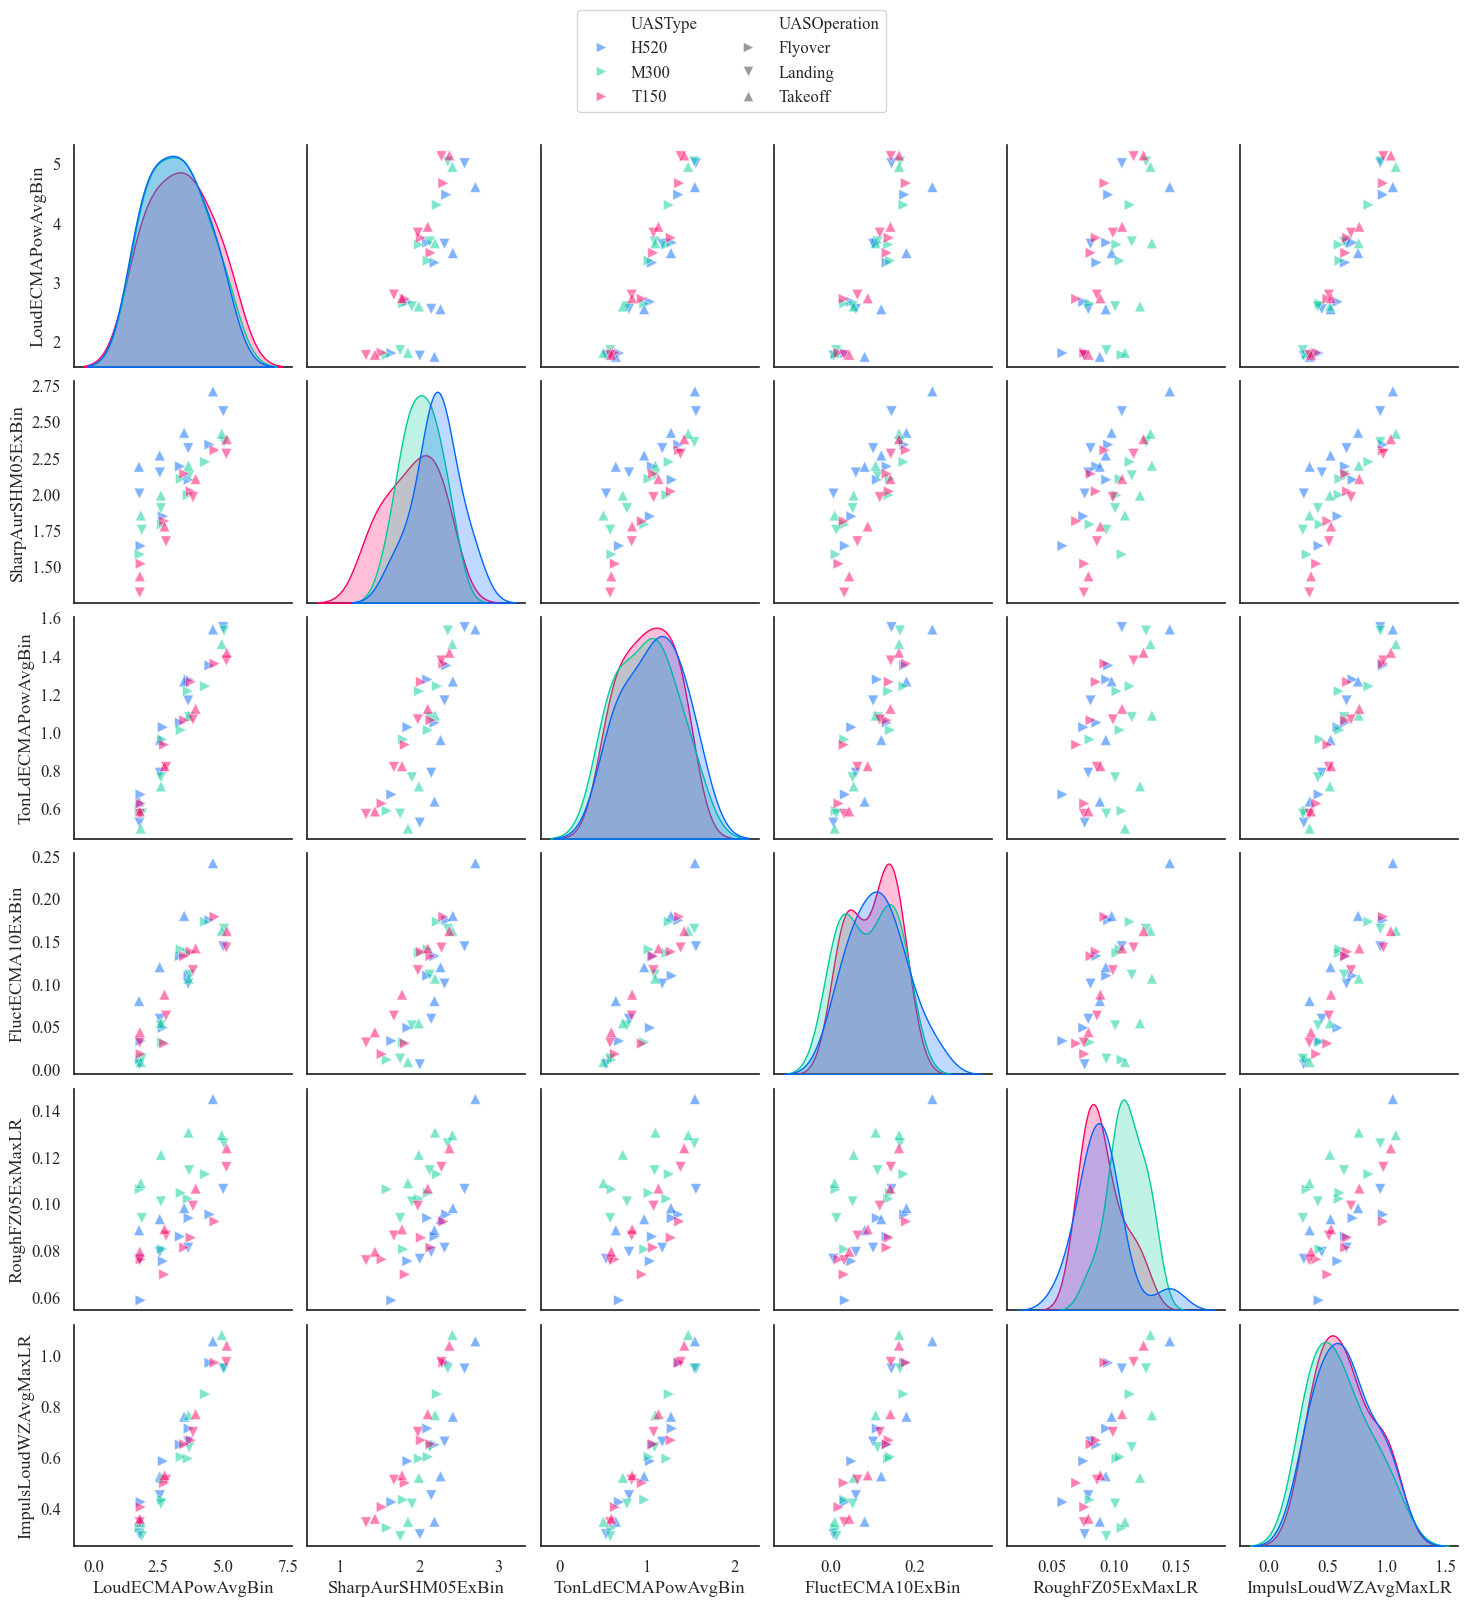

In [ ]:
# pairwise plots for absolute SQMs influencing mean change in annoyance
# using auxData to avoid data duplication, SQMs do not need 'UAS' prefix
metrics = ["LoudECMAPowAvgBin", "SharpAurSHM05ExBin", "TonLdECMAPowAvgBin",
           "FluctECMA10ExBin", "RoughFZ05ExMaxLR", "ImpulsLoudWZAvgMaxLR"]

map_to_marker = {'Takeoff': '^', 'Overflight': '>', 'Landing': 'v'}

scatter_kws = {'s': 60, 'alpha': 0.5, 'style': auxData['UASOperation'],  'markers': map_to_marker}

sns.set_theme(style='white', font_scale=1.1, font='serif')

pplot = sns.pairplot(data=auxData.loc[auxData['SessionPart']=="A", :],
                     hue="UASType", palette=mycolours[0:3], vars=metrics,
                     corner=False, plot_kws=scatter_kws)

sns.move_legend(
    pplot, loc="upper center", bbox_to_anchor=(0.45, 1.08), title=None, frameon=True, ncols=2
)

filename = "PtASQMdAnnoyLoudPairwise"

if saveplots:
    pplot.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                    format='svg')
    pplot.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                    format='pdf')


sns.set_theme(style='white', font_scale=1)

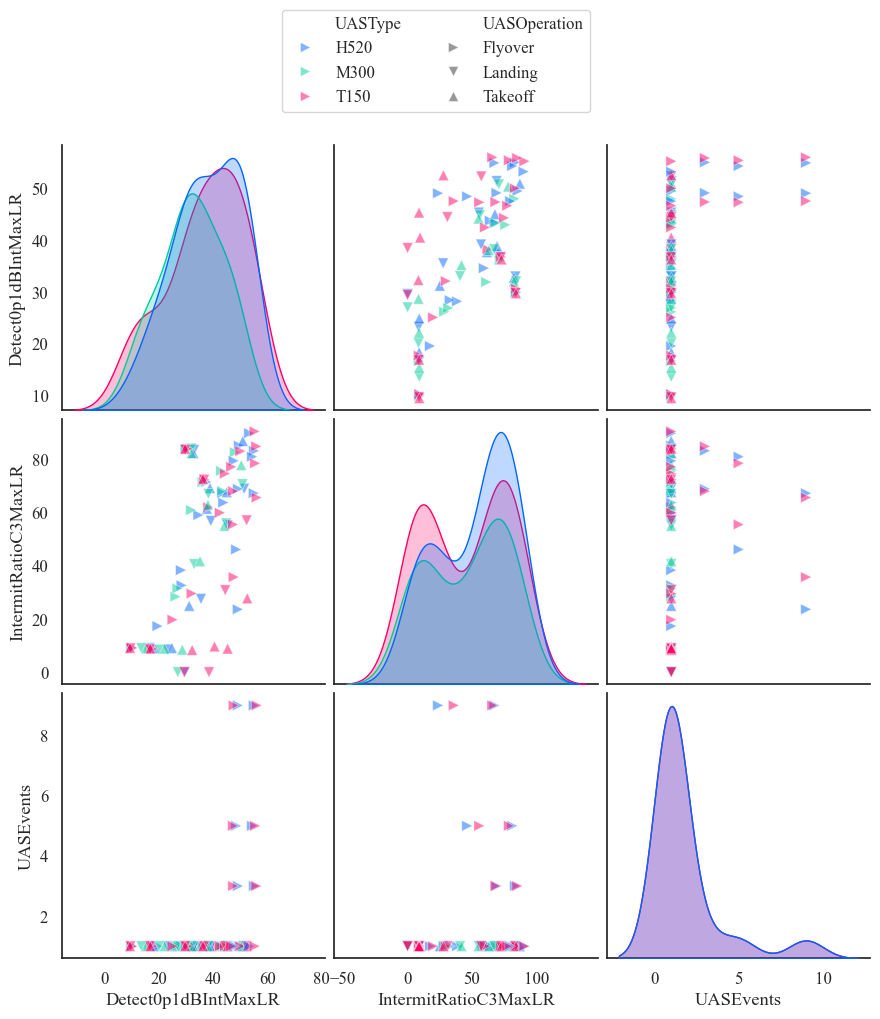

In [ ]:
metrics = ["Detect0p1dBIntMaxLR", "IntermitRatioC3MaxLR", "UASEvents"]

map_to_marker = {'Takeoff': '^', 'Overflight': '>', 'Landing': 'v'}


data = dataByStimTest.loc[dataByStimTest['UASOperation'] != "No UAS", :]

for dataset in [data]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["Overflight", "Landing", "Takeoff"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["H520", "M300", "T150"], ordered=True)

map_to_marker = {'Takeoff': '^', 'Overflight': '>', 'Landing': 'v'}

scatter_kws = {'s': 60, 'alpha': 0.5, 'style': data['UASOperation'],
               'markers': map_to_marker}

sns.set_theme(style='white', font_scale=1.1, font='serif')

pplot = sns.pairplot(data=data,
                     hue="UASType", palette=mycolours[0:3], vars=metrics,
                     corner=False, plot_kws=scatter_kws, height=3)

sns.move_legend(
    pplot, loc="upper center", bbox_to_anchor=(0.42, 1.14), title=None, frameon=True, ncols=2
)

filename = "PtsABEvtMetricsdHiAnnoyPairwise"

if saveplots:
    pplot.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                    format='svg')
    pplot.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                    format='pdf')


sns.set_theme(style='white', font_scale=1)

### UAS noticed

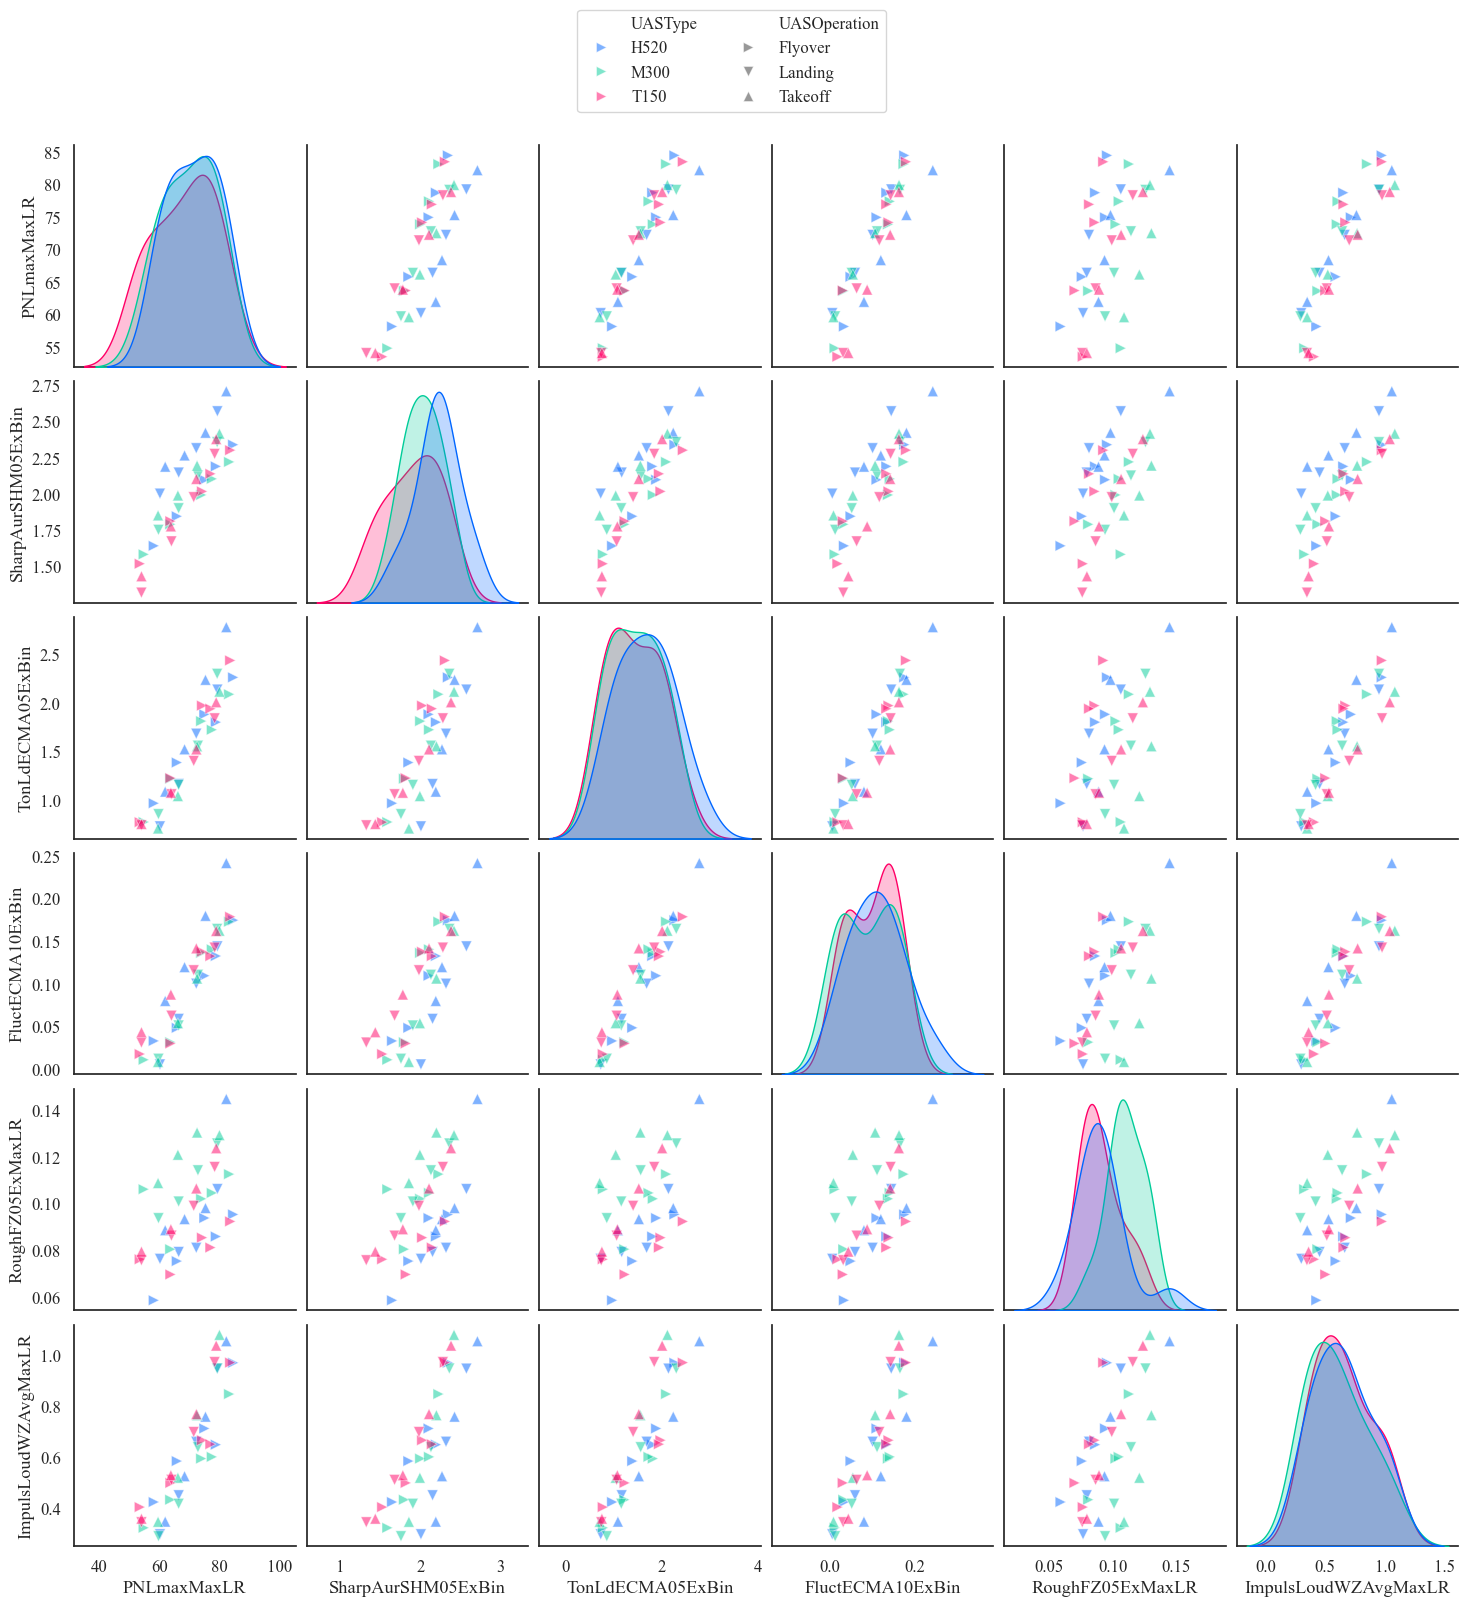

In [ ]:
# pairwise plots for absolute SQMs influencing % UAS noticed
# using auxData to avoid data duplication, SQMs do not need 'UAS' prefix
metrics = ["PNLmaxMaxLR", "SharpAurSHM05ExBin", "TonLdECMA05ExBin",
           "FluctECMA10ExBin", "RoughFZ05ExMaxLR", "ImpulsLoudWZAvgMaxLR"]

map_to_marker = {'Takeoff': '^', 'Overflight': '>', 'Landing': 'v'}

scatter_kws = {'s': 60, 'alpha': 0.5, 'style': auxData['UASOperation'],  'markers': map_to_marker}

sns.set_theme(style='white', font_scale=1.1, font='serif')

pplot = sns.pairplot(data=auxData.loc[auxData['SessionPart']=="A", :], hue="UASType",
                     palette=mycolours[0:3], vars=metrics,
                     corner=False, plot_kws=scatter_kws)

sns.move_legend(
    pplot, loc="upper center", bbox_to_anchor=(0.45, 1.08), title=None, frameon=True, ncols=2
)

filename = "PtASQMNoticePairwise"

if saveplots:
    pplot.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                    format='svg')
    pplot.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                    format='pdf')


sns.set_theme(style='white', font_scale=1)


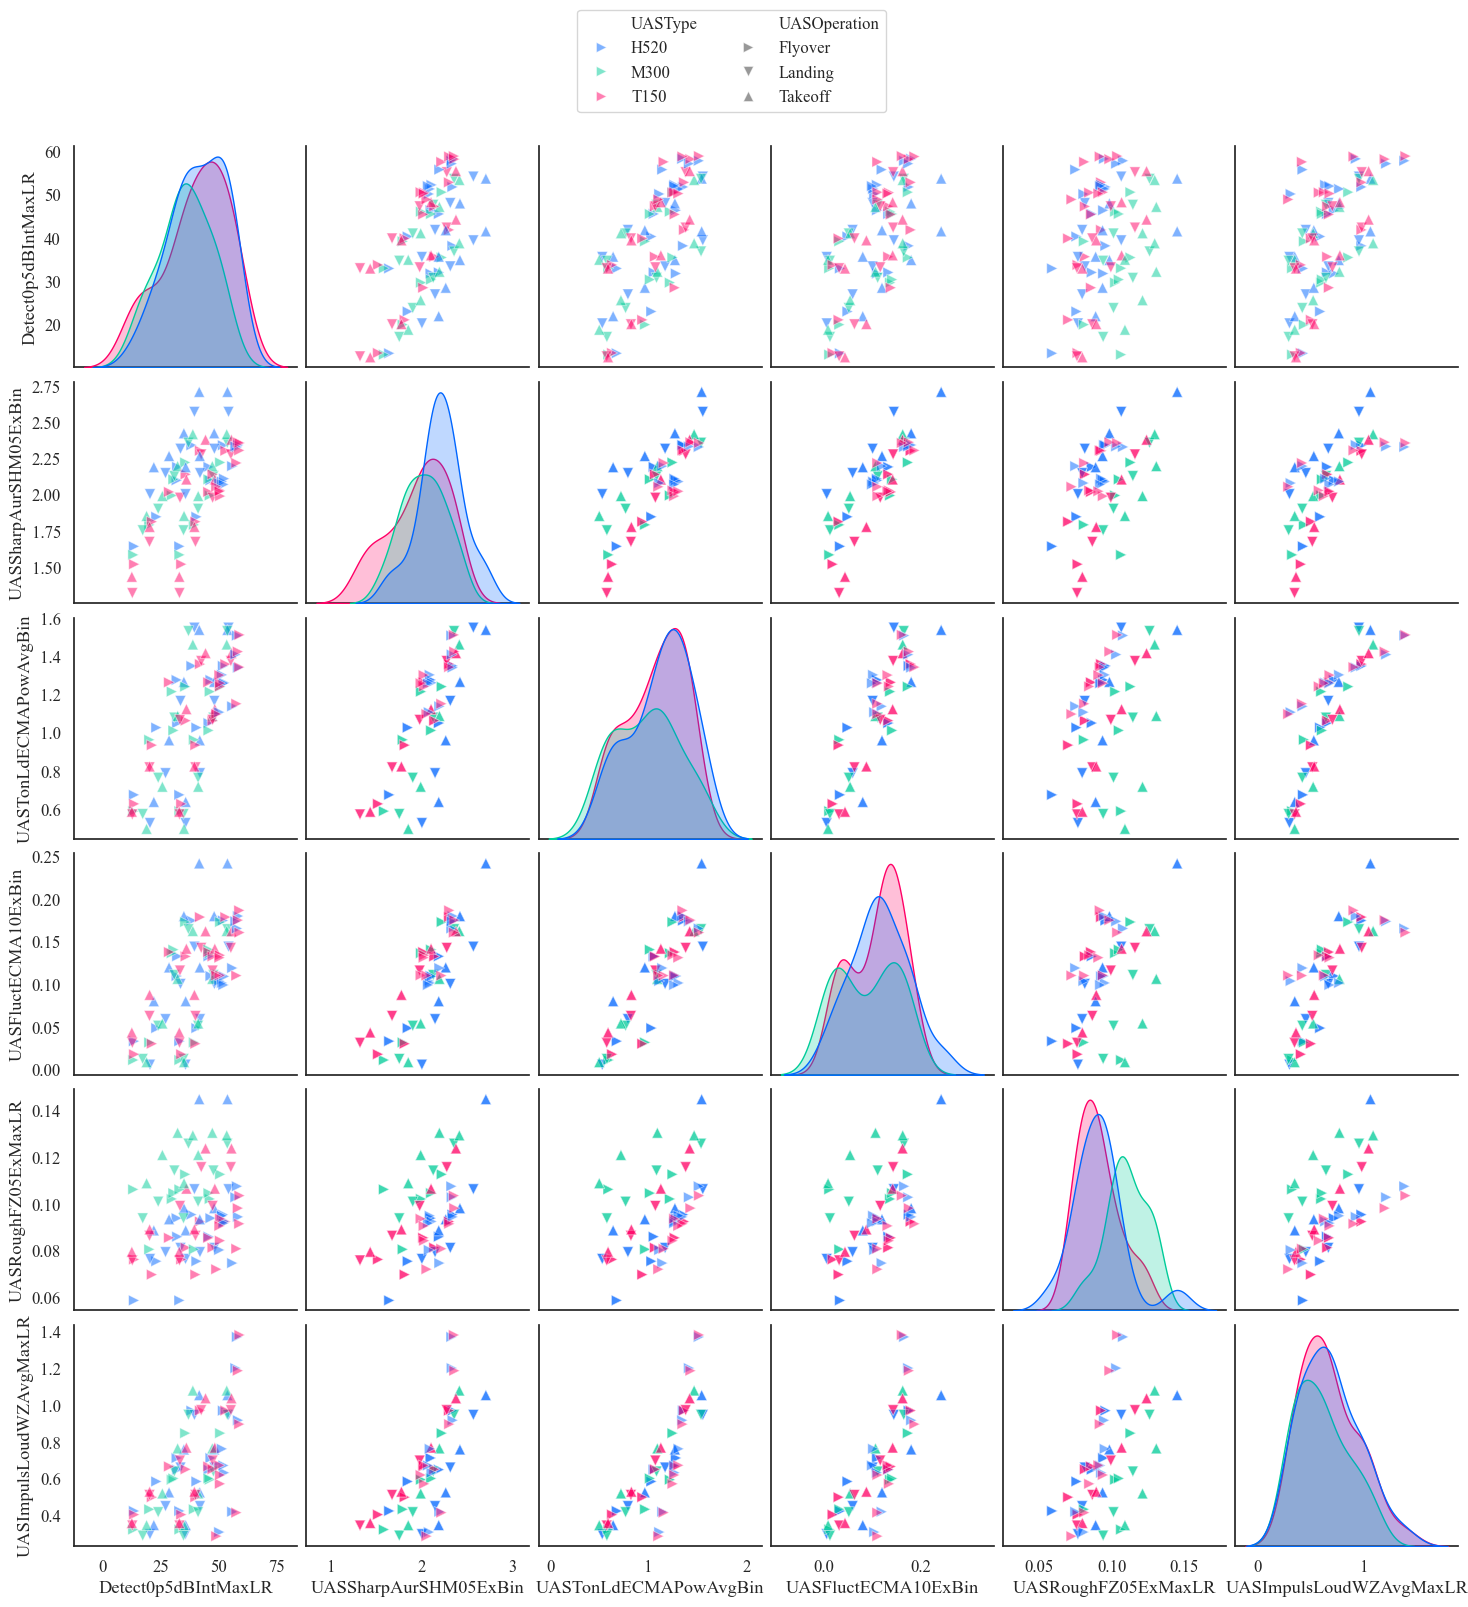

In [ ]:
# pairwise plots for absolute SQMs influencing mean change in annoyance
metrics = ["Detect0p5dBIntMaxLR", "UASSharpAurSHM05ExBin", "UASTonLdECMAPowAvgBin",
           "UASFluctECMA10ExBin", "UASRoughFZ05ExMaxLR", "UASImpulsLoudWZAvgMaxLR"]

data = dataByStimTest.loc[dataByStimTest['UASOperation'] != "No UAS", :]

for dataset in [data]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["Overflight", "Landing", "Takeoff"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["H520", "M300", "T150"], ordered=True)

map_to_marker = {'Takeoff': '^', 'Overflight': '>', 'Landing': 'v'}

scatter_kws = {'s': 60, 'alpha': 0.5, 'style': data['UASOperation'],
               'markers': map_to_marker}

sns.set_theme(style='white', font_scale=1.1, font='serif')

pplot = sns.pairplot(data=data,
                     hue="UASType", palette=mycolours[0:3], vars=metrics,
                     corner=False, plot_kws=scatter_kws)

sns.move_legend(
    pplot, loc="upper center", bbox_to_anchor=(0.45, 1.08), title=None, frameon=True, ncols=2
)

filename = "PtsABSQMdAnnoyDetectPairwise"
if saveplots:
    pplot.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                    format='svg')
    pplot.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                    format='pdf')

sns.set_theme(style='white', font_scale=1)


## Correlations between responses and metrics

### UAS noticed

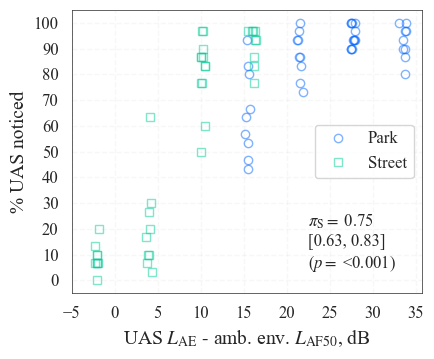

In [83]:
# Generate scatter charts for noticeability and LAELAF50diff

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTestANotice.loc[:, 'LAELAF50diff'],
                   dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'LAELAF50diff'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Park")

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'LAELAF50diff'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'NoticedPropFilt'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Street")

ax.set(xlabel=r"UAS $L_\mathrm{AE}$ - amb. env. $L_\mathrm{AF50}$, dB",
       ylabel=r"% UAS noticed",
       xticks=np.arange(-5, 40, 5),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(22.5, 0.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')
ax.legend(loc='center right')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

if saveplots:
    filename = "PtANoticeLAELAF50diffByAmb"
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

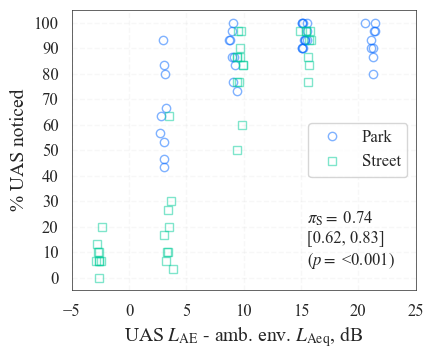

In [84]:
# Generate scatter charts for noticeability and LAELAeq

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTestANotice.loc[:, 'LAELAeqdiff'],
                   dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'LAELAeqdiff'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Park")

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'LAELAeqdiff'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'NoticedPropFilt'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Street")

ax.set(xlabel=r"UAS $L_\mathrm{AE}$ - amb. env. $L_\mathrm{Aeq}$, dB",
       ylabel=r"% UAS noticed",
       xticks=np.arange(-5, 30, 5),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(15.5, 0.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')
ax.legend(loc='center right')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

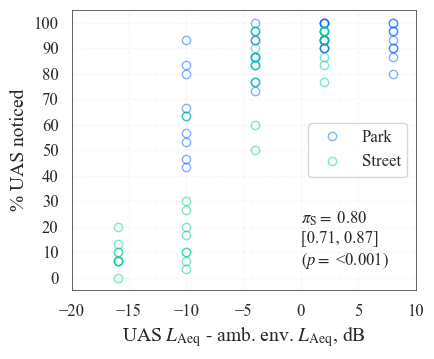

In [85]:
# Generate scatter charts for noticeability and LAELAeq

# prepare data
data = dataByStimTestANotice.copy()
dictSNR = {0: "No UAS", 1: -16, 2: -10, 3: -4, 4: 2, 5: 8}
data['SNRlevel'].cat.codes.map(dictSNR)
data = data.loc[data['SNRlevel'] != "No UAS", :]
data['SNRlevel'] = pd.to_numeric(data['SNRlevel'])

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(data.loc[:, 'SNRlevel'],
                   data.loc[:, 'NoticedPropFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(data.loc[data['AmbientEnv']=="Park", 'SNRlevel'],
        data.loc[data['AmbientEnv']=="Park", 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Park")

ax.plot(data.loc[data['AmbientEnv']=="Street", 'SNRlevel'],
        data.loc[data['AmbientEnv']=="Street", 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Street")

ax.set(xlabel=r"UAS $L_\mathrm{Aeq}$ - amb. env. $L_\mathrm{Aeq}$, dB",
       ylabel=r"% UAS noticed",
       xticks=np.arange(-20, 15, 5),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(0, 0.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')
ax.legend(loc='center right')

if saveplots:
    filename = "PtANoticeSNRByAmb"
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

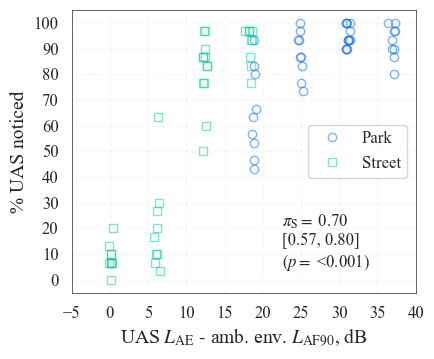

In [86]:
# Generate scatter charts for noticeability and LAELAF90

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTestANotice.loc[:, 'LAELAF90diff'],
                   dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'LAELAF90diff'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Park")

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'LAELAF90diff'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'NoticedPropFilt'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Street")

ax.set(xlabel=r"UAS $L_\mathrm{AE}$ - amb. env. $L_\mathrm{AF90}$, dB",
       ylabel=r"% UAS noticed",
       xticks=np.arange(-5, 45, 5),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(22.5, 0.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')
ax.legend(loc='center right')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

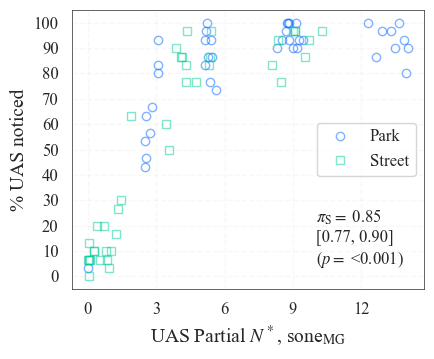

In [87]:
# Generate scatter charts for noticeability and partial loudness

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTestANotice.loc[:, 'PartLoudMGSTPowAvg'],
                   dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'PartLoudMGSTPowAvg'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Park", 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Park")

ax.plot(dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'PartLoudMGSTPowAvg'],
        dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']=="Street", 'NoticedPropFilt'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Street")

ax.set(xlabel=r"UAS Partial $N^*$, sone$_{\mathrm{MG}}$",
       ylabel=r"% UAS noticed",
       xticks=np.arange(0, 15, 3),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(10, 0.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')
ax.legend(loc='center right')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

if saveplots:
    filename = "PtANoticeVsPartLoudPowByAmbFilt"
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

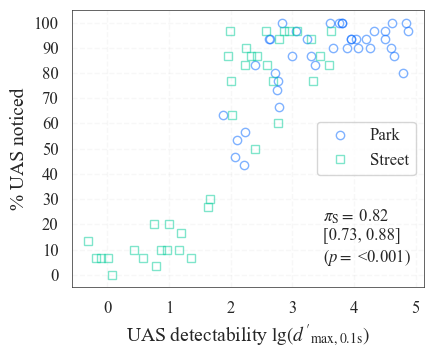

In [88]:
# Generate scatter charts for noticeability and lg(detectability)

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTestANotice.loc[:, 'Detect0p1MaxMaxLRLog'],
                   dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(data.loc[data['AmbientEnv']=="Park", 'Detect0p1MaxMaxLRLog'],
        data.loc[data['AmbientEnv']=="Park", 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Park")

ax.plot(data.loc[data['AmbientEnv']=="Street", 'Detect0p1MaxMaxLRLog'],
        data.loc[data['AmbientEnv']=="Street", 'NoticedPropFilt'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5,
        label="Street")

ax.set(xlabel=r"UAS detectability $\mathrm{lg}(d'_{\mathrm{max,0.1s}})$",
       ylabel=r"% UAS noticed",
       xticks=np.arange(0, 6, 1),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(3.5, 0.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')
ax.legend(loc='center right')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

filename = "PtANoticeDetectCorrByAmb"
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()

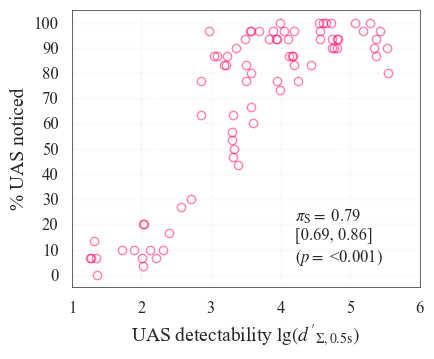

In [89]:
# Generate scatter charts for noticeability and lg(detectability)

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTestANotice.loc[:, 'Detect0p5IntMaxLRLog'],
                   dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTestANotice.loc[:, 'Detect0p5IntMaxLRLog'],
        dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[2], markeredgewidth=1,
        color='none', alpha=0.5)

ax.set(xlabel=r"UAS detectability $\mathrm{lg}(d'_{\mathrm{\Sigma,0.5s}})$",
       ylabel=r"% UAS noticed",
       xticks=np.arange(1, 7, 1),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(4.2, 0.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

filename = "PtANoticeDetectCorr"
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')
plt.show()

### Annoyance

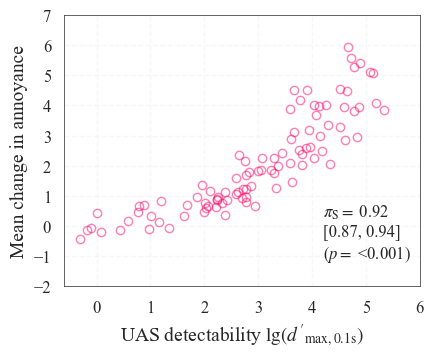

In [90]:
# Generate scatter charts for mean change in annoyance and lg(detectability)

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTest.loc[:, 'Detect0p1MaxMaxLRLog'],
                   dataByStimTest.loc[:, 'dAnnoyMean'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'Detect0p1MaxMaxLRLog'],
        dataByStimTest.loc[:, 'dAnnoyMean'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[2], markeredgewidth=1,
        color='none', alpha=0.5)

ax.set(xlabel=r"UAS detectability $\mathrm{lg}(d'_{\mathrm{max,0.1s}})$",
       ylabel=r"Mean change in annoyance",
       xticks=np.arange(0, 7, 1),
       yticks=np.arange(-2, 8, 1))
ax.text(4.2, -1.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

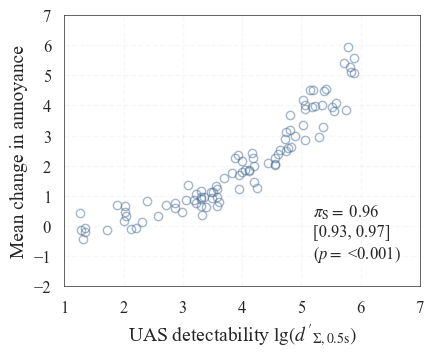

In [91]:
# Generate scatter charts for mean change in annoyance and lg(detectability)

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTest.loc[:, 'Detect0p5IntMaxLRLog'],
                   dataByStimTest.loc[:, 'dAnnoyMean'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'Detect0p5IntMaxLRLog'],
        dataByStimTest.loc[:, 'dAnnoyMean'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[3], markeredgewidth=1,
        color='none', alpha=0.5)

ax.set(xlabel=r"UAS detectability $\mathrm{lg}(d'_{\mathrm{\Sigma,0.5s}})$",
       ylabel=r"Mean change in annoyance",
       xticks=np.arange(1, 8, 1),
       yticks=np.arange(-2, 8, 1))
ax.text(5.2, -1.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

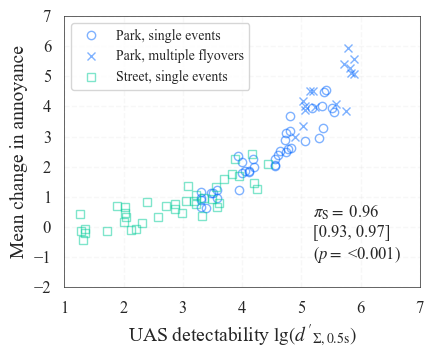

In [ ]:
# Generate scatter charts for mean change in annoyance and lg(detectability), separated colours

fig, ax = plt.subplots(figsize=(4.5, 3.75))

dataByStimTest['Detect0p5IntMaxLRLog'] = dataByStimTest['Detect0p5dBIntMaxLR']/10

testCorr = pg.corr(dataByStimTest.loc[:, 'Detect0p5IntMaxLRLog'],
                   dataByStimTest.loc[:, 'dAnnoyMean'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="A"), 'Detect0p5IntMaxLRLog'],
        dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="A"), 'dAnnoyMean'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5, label="Park, single events")

ax.plot(dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="B"), 'Detect0p5IntMaxLRLog'],
        dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="B"), 'dAnnoyMean'],
        marker='x', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5, label="Park, multiple Overflights")

ax.plot(dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Street")
                           & (dataByStimTest['SessionPart']=="A"), 'Detect0p5IntMaxLRLog'],
        dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Street")
                           & (dataByStimTest['SessionPart']=="A"), 'dAnnoyMean'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5, label="Street, single events")

ax.set(xlabel=r"UAS detectability $\mathrm{lg}(d'_{\mathrm{\Sigma,0.5s}})$",
       ylabel=r"Mean change in annoyance",
       xticks=np.arange(1, 8, 1),
       yticks=np.arange(-2, 8, 1))
ax.text(5.2, -1.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

ax.legend(loc='upper left', fontsize=10)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

filename = "PtsABdAnnoyMnDetectCorrByAmb"
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')
plt.show()

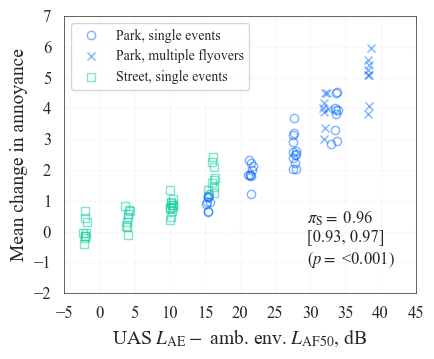

In [ ]:
# Generate scatter charts for mean change in annoyance and LAELAF50diff

fig, ax = plt.subplots(figsize=(4.5, 3.75))


testCorr = pg.corr(dataByStimTest.loc[:, 'LAELAF50diff'],
                   dataByStimTest.loc[:, 'dAnnoyMean'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="A"), 'LAELAF50diff'],
        dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="A"), 'dAnnoyMean'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5, label="Park, single events")

ax.plot(dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="B"), 'LAELAF50diff'],
        dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Park")
                           & (dataByStimTest['SessionPart']=="B"), 'dAnnoyMean'],
        marker='x', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5, label="Park, multiple Overflights")

ax.plot(dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Street")
                           & (dataByStimTest['SessionPart']=="A"), 'LAELAF50diff'],
        dataByStimTest.loc[(dataByStimTest['AmbientEnv']=="Street")
                           & (dataByStimTest['SessionPart']=="A"), 'dAnnoyMean'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5, label="Street, single events")

ax.set(xlabel=r"UAS $L_\mathrm{AE}-$ amb. env. $L_\mathrm{AF50}$, dB",
       ylabel=r"Mean change in annoyance",
       xticks=np.arange(-5, 50, 5),
       yticks=np.arange(-2, 8, 1))
ax.text(29.5, -1.05, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

ax.legend(loc='upper left', fontsize=10)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

filename = "PtsABdAnnoyMndLAECorrByAmb"
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')
    
plt.show()

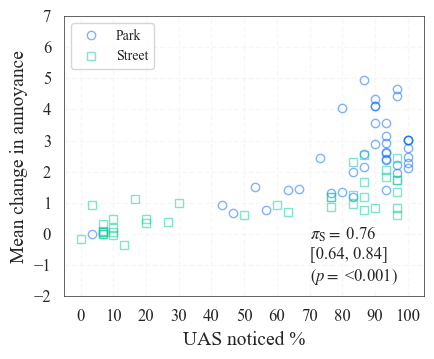

In [94]:
# Generate scatter charts for mean change in annoyance and noticeability, separated colours

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTestANotice.loc[:, 'NoticedPropFilt'],
                   dataByStimTestANotice.loc[:, 'dAnnoyMeanFilt'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTestANotice.loc[(dataByStimTestANotice['AmbientEnv']=="Park")
                           & (dataByStimTestANotice['SessionPart']=="A"), 'NoticedPropFilt'],
        dataByStimTestANotice.loc[(dataByStimTestANotice['AmbientEnv']=="Park")
                           & (dataByStimTestANotice['SessionPart']=="A"), 'dAnnoyMeanFilt'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5, label="Park")

ax.plot(dataByStimTestANotice.loc[(dataByStimTestANotice['AmbientEnv']=="Street")
                           & (dataByStimTestANotice['SessionPart']=="A"), 'NoticedPropFilt'],
        dataByStimTestANotice.loc[(dataByStimTestANotice['AmbientEnv']=="Street")
                           & (dataByStimTestANotice['SessionPart']=="A"), 'dAnnoyMeanFilt'],
        marker='s', markerfacecolor='none', markeredgecolor=mycolours[1], markeredgewidth=1,
        color='none', alpha=0.5, label="Street")

ax.set(xlabel=r"UAS noticed %",
       ylabel=r"Mean change in annoyance",
       xticks=np.arange(0, 1.1, 0.1),
       xticklabels=np.arange(0, 110, 10),
       yticks=np.arange(-2, 8, 1))
ax.text(0.7, -1.5, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

ax.legend(loc='upper left', fontsize=10)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

filename = "PtAdAnnoyMnNoticeCorrByAmb"
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')
plt.show()

### % Highly annoyed | HA'amb

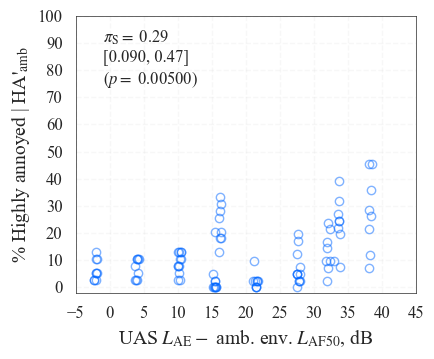

In [95]:
# Generate scatter charts for % highly annoyed and LAELAF50diff

fig, ax = plt.subplots(figsize=(4.5, 3.75))


testCorr = pg.corr(dataByStimTest.loc[:, 'LAELAF50diff'],
                   dataByStimTest.loc[:, 'dHighAnnoyProp'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'LAELAF50diff'],
        dataByStimTest.loc[:, 'dHighAnnoyProp'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[0], markeredgewidth=1,
        color='none', alpha=0.5)

ax.set(xlabel=r"UAS $L_\mathrm{AE}-$ amb. env. $L_\mathrm{AF50}$, dB",
       ylabel=r"% Highly annoyed | HA'$_\mathrm{amb}$",
       xticks=np.arange(-5, 50, 5),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(-1, 0.75, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

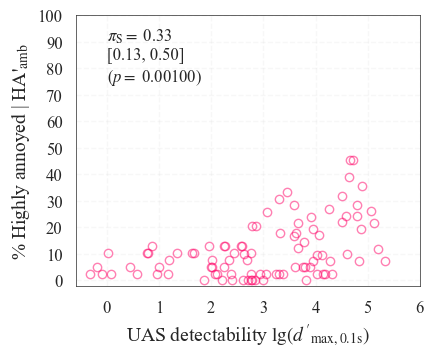

In [96]:
# Generate scatter charts for % highly annoyed and Detect0p1MaxMaxLRLog

fig, ax = plt.subplots(figsize=(4.5, 3.75))


testCorr = pg.corr(dataByStimTest.loc[:, 'Detect0p1MaxMaxLRLog'],
                   dataByStimTest.loc[:, 'dHighAnnoyProp'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'Detect0p1MaxMaxLRLog'],
        dataByStimTest.loc[:, 'dHighAnnoyProp'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[2],
        markeredgewidth=1, color='none', alpha=0.5)

ax.set(xlabel=r"UAS detectability $\mathrm{lg}(d'_{\mathrm{max,0.1s}})$",
       ylabel=r"% Highly annoyed | HA'$_\mathrm{amb}$",
       xticks=np.arange(0, 7, 1),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(0, 0.75, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()


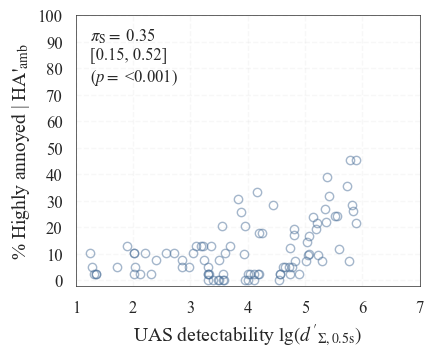

In [97]:
# Generate scatter charts for % highly annoyed and Detect0p5IntMaxLRLog

fig, ax = plt.subplots(figsize=(4.5, 3.75))


testCorr = pg.corr(dataByStimTest.loc[:, 'Detect0p5IntMaxLRLog'],
                   dataByStimTest.loc[:, 'dHighAnnoyProp'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'Detect0p5IntMaxLRLog'],
        dataByStimTest.loc[:, 'dHighAnnoyProp'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[3],
        markeredgewidth=1, color='none', alpha=0.5)

ax.set(xlabel=r"UAS detectability $\mathrm{lg}(d'_{\mathrm{\Sigma,0.5s}})$",
       ylabel=r"% Highly annoyed | HA'$_\mathrm{amb}$",
       xticks=np.arange(1, 8, 1),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(1.25, 0.75, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()


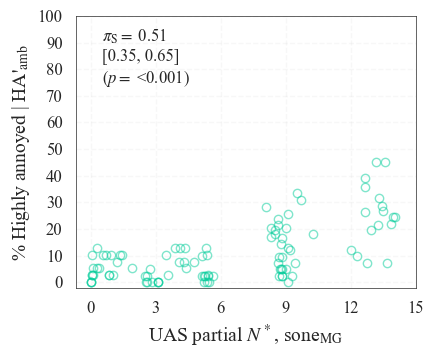

In [98]:
# Generate scatter charts for % highly annoyed and partial loudness

fig, ax = plt.subplots(figsize=(4.5, 3.75))


testCorr = pg.corr(dataByStimTest.loc[:, 'PartLoudMGSTPowAvg'],
                   dataByStimTest.loc[:, 'dHighAnnoyProp'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'PartLoudMGSTPowAvg'],
        dataByStimTest.loc[:, 'dHighAnnoyProp'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[1],
        markeredgewidth=1, color='none', alpha=0.5)

ax.set(xlabel=r"UAS partial $N^*$, sone$_{\mathrm{MG}}$",
       ylabel=r"% Highly annoyed | HA'$_\mathrm{amb}$",
       xticks=np.arange(0, 18, 3),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(0.5, 0.75, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()



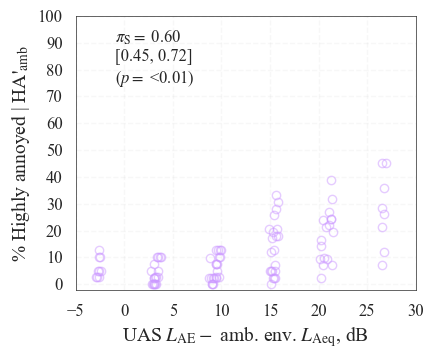

In [99]:
# Generate scatter charts for % highly annoyed and LAELAeqdiff

fig, ax = plt.subplots(figsize=(4.5, 3.75))


testCorr = pg.corr(dataByStimTest.loc[:, 'LAELAeqdiff'],
                   dataByStimTest.loc[:, 'dHighAnnoyProp'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 2)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'LAELAeqdiff'],
        dataByStimTest.loc[:, 'dHighAnnoyProp'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[5],
        markeredgewidth=1, color='none', alpha=0.5)

ax.set(xlabel=r"UAS $L_\mathrm{AE} -$ amb. env. $L_\mathrm{Aeq}$, dB",
       ylabel=r"% Highly annoyed | HA'$_\mathrm{amb}$",
       xticks=np.arange(-5, 35, 5),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(-1, 0.75, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + str(rCI[0]) + ", " + str(rCI[1]) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()


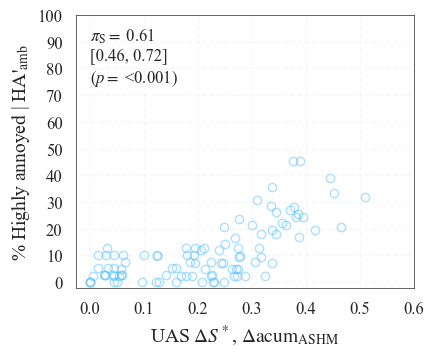

In [24]:
# Generate scatter charts for % highly annoyed and dSharpAurSHMPowAvgBin 

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTest.loc[:, 'dSharpAurSHMPowAvgBin'],
                   dataByStimTest.loc[:, 'dHighAnnoyProp'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'dSharpAurSHMPowAvgBin'],
        dataByStimTest.loc[:, 'dHighAnnoyProp'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[6],
        markeredgewidth=1, color='none', alpha=0.5)

ax.set(xlabel=r"UAS $\Delta S^*$, $\Delta\mathrm{acum_{ASHM}}$",
       ylabel=r"% Highly annoyed | HA'$_\mathrm{amb}$",
       xticks=np.arange(0, 0.7, 0.1),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(0, 0.75, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

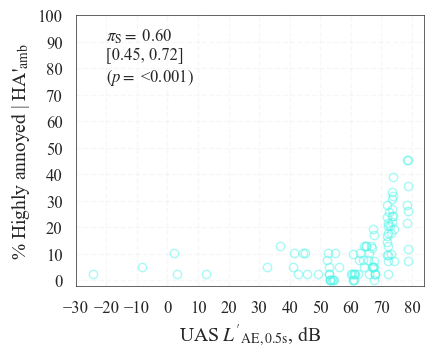

In [101]:
# Generate scatter charts for % highly annoyed and UASDisc0p5LAEMaxLR 

fig, ax = plt.subplots(figsize=(4.5, 3.75))

testCorr = pg.corr(dataByStimTest.loc[:, 'UASDisc0p5LAEMaxLR'],
                   dataByStimTest.loc[:, 'dHighAnnoyProp'],
                   method='shepherd',
                   n_boot=10000)

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.plot(dataByStimTest.loc[:, 'UASDisc0p5LAEMaxLR'],
        dataByStimTest.loc[:, 'dHighAnnoyProp'],
        marker='o', markerfacecolor='none', markeredgecolor=mycolours[7],
        markeredgewidth=1, color='none', alpha=0.5)

ax.set(xlabel=r"UAS $L'_\mathrm{AE,0.5s}$, dB",
       ylabel=r"% Highly annoyed | HA'$_\mathrm{amb}$",
       xticks=np.arange(-30, 90, 10),
       yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.text(-20, 0.75, r"$\pi_\mathrm{S}=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2) + ", "
        + displayRndVal(rCI[1], 2) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")
ax.grid(which='both', alpha=0.15, linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.show()

## Time-dependent

### Loudness

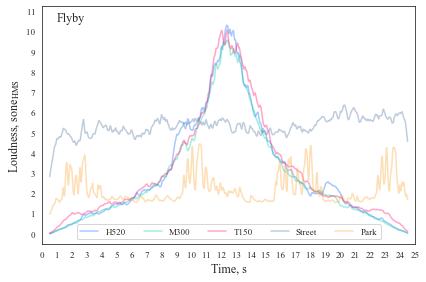

In [26]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel=r"Loudness, sone$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepFlyby.svg"), format='svg')
plt.show()

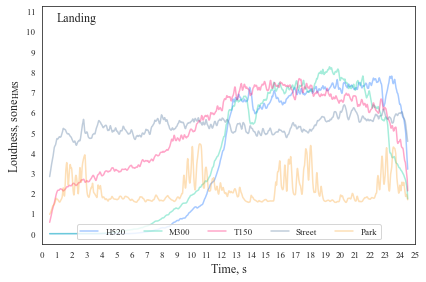

In [27]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel=r"Loudness, sone$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepLanding.svg"), format='svg')
plt.show()

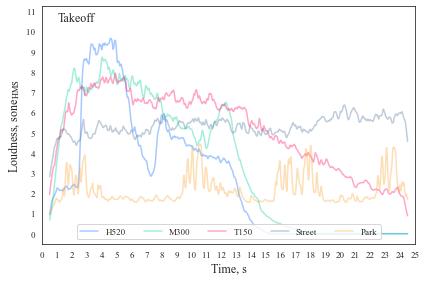

In [28]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel=r"Loudness, sone$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepTakeoff.svg"), format='svg')
plt.show()

### Sharpness

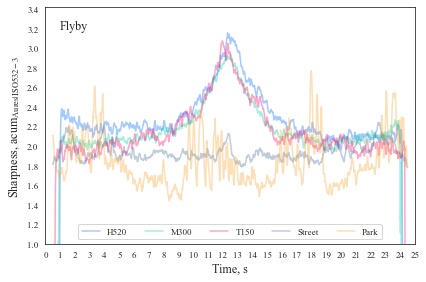

In [29]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(1, 4, 0.2), xlim=[0, 25], ylim=[1, 3.425],
       xlabel="Time, s", ylabel=r"Sharpness, acum$_\text{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=3.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepFlyby.svg"), format='svg')
plt.show()

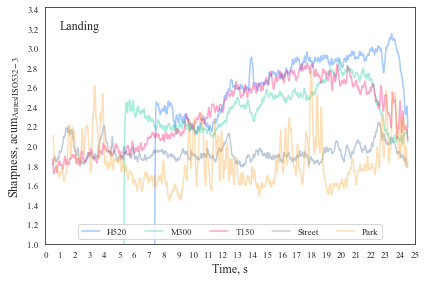

In [30]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(1, 4, 0.2), xlim=[0, 25], ylim=[1, 3.425],
       xlabel="Time, s", ylabel=r"Sharpness, acum$_\text{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=3.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepLanding.svg"), format='svg')
plt.show()

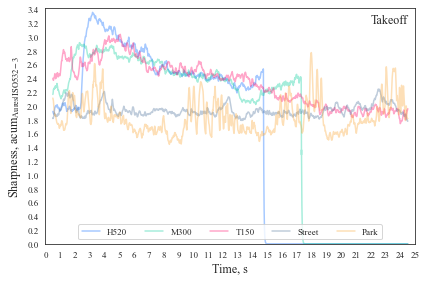

In [48]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 4, 0.2), xlim=[0, 25], ylim=[0, 3.425],
       xlabel="Time, s", ylabel=r"Sharpness, acum$_\text{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=22, y=3.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepTakeoff.svg"), format='svg')
plt.show()

### Tonality

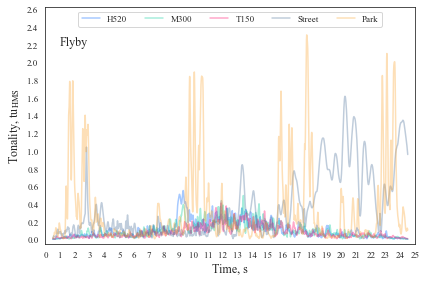

In [32]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel=r"Tonality, tu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepFlyby.svg"), format='svg')
plt.show()

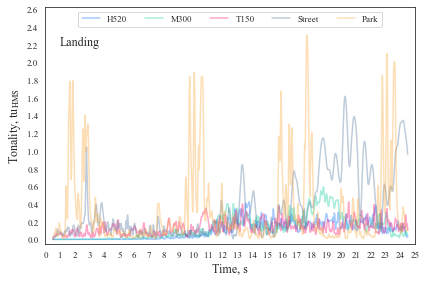

In [33]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel=r"Tonality, tu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepLanding.svg"), format='svg')
plt.show()

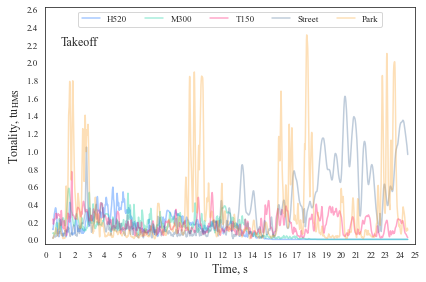

In [34]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel=r"Tonality, tu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepTakeoff.svg"), format='svg')
plt.show()

### Fluctuation strength

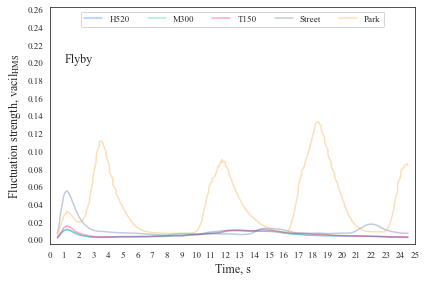

In [35]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel=r"Fluctuation strength, vacil$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepFlyby.svg"), format='svg')
plt.show()

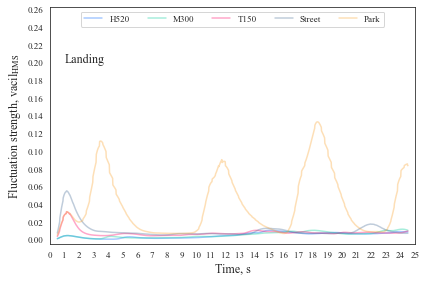

In [36]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel=r"Fluctuation strength, vacil$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepLanding.svg"), format='svg')
plt.show()

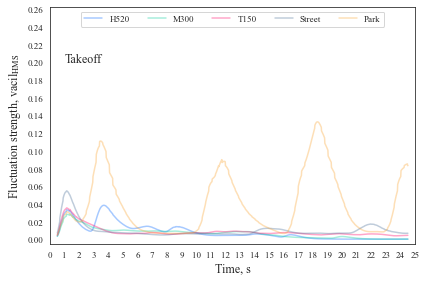

In [37]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel=r"Fluctuation strength, vacil$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepTakeoff.svg"), format='svg')
plt.show()

### Roughness

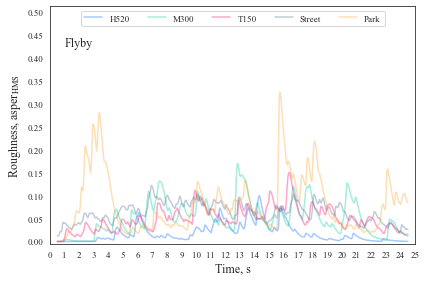

In [38]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.55, 0.05), xlim=[0, 25], ylim=[-0.005, 0.5125],
       xlabel="Time, s", ylabel=r"Roughness, asper$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepFlyby.svg"), format='svg')
plt.show()

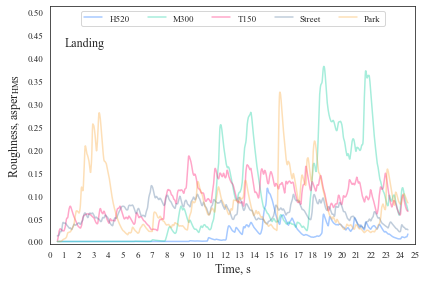

In [39]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.55, 0.05), xlim=[0, 25], ylim=[-0.005, 0.5125],
       xlabel="Time, s", ylabel=r"Roughness, asper$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepLanding.svg"), format='svg')
plt.show()

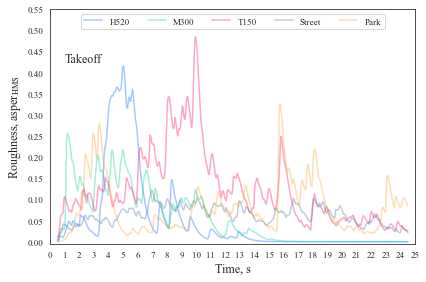

In [43]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.6, 0.05), xlim=[0, 25], ylim=[-0.005, 0.55],
       xlabel="Time, s", ylabel=r"Roughness, asper$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepTakeoff.svg"), format='svg')
plt.show()

### Impulsiveness

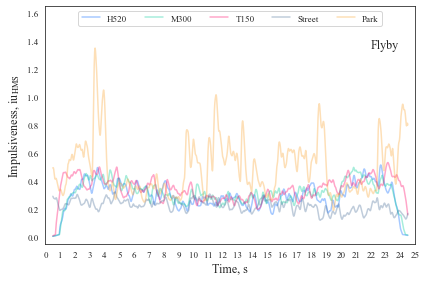

In [44]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel=r"Impulsiveness, iu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepFlyby.svg"), format='svg')
plt.show()

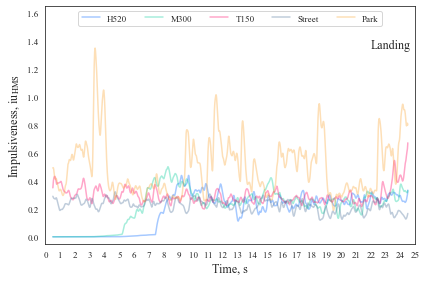

In [45]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel=r"Impulsiveness, iu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepLanding.svg"), format='svg')
plt.show()

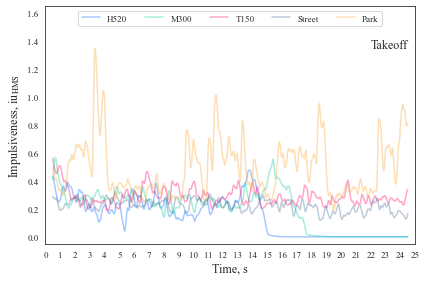

In [46]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel=r"Impulsiveness, iu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepTakeoff.svg"), format='svg')
plt.show()